<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [62]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [63]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [64]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

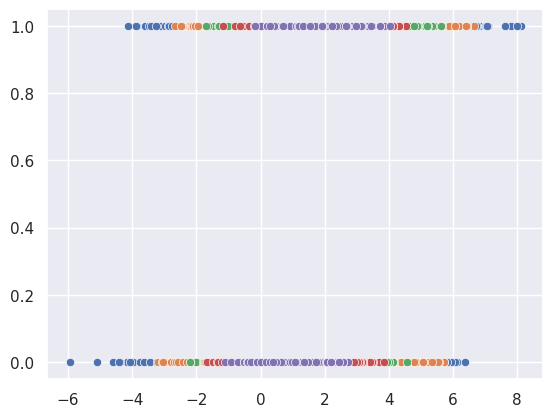

In [65]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

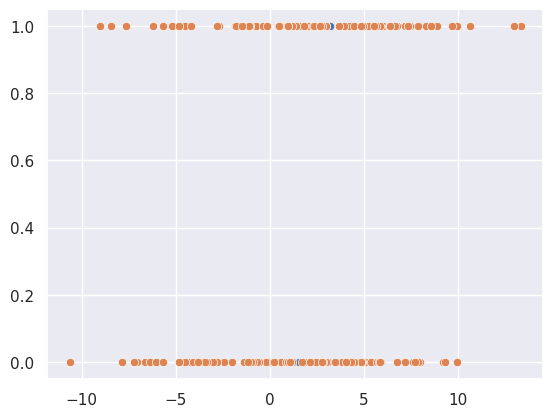

In [66]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [67]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [68]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 11.55it/s]


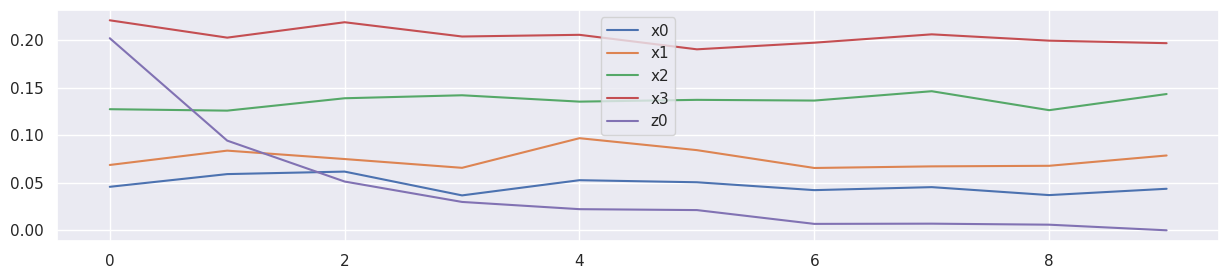

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 48.57it/s]


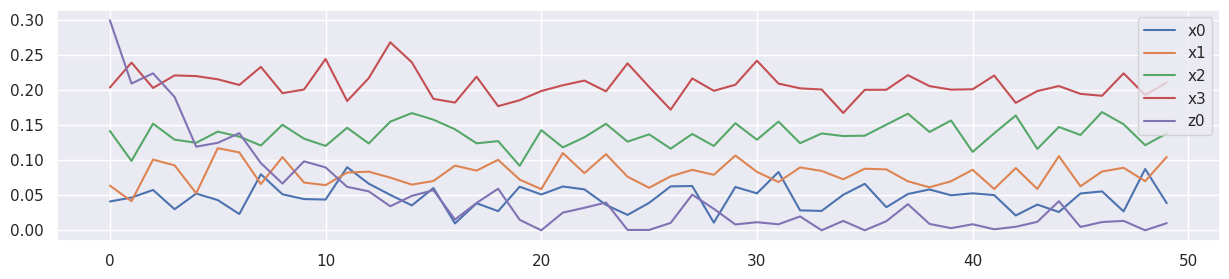

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 76.65it/s]


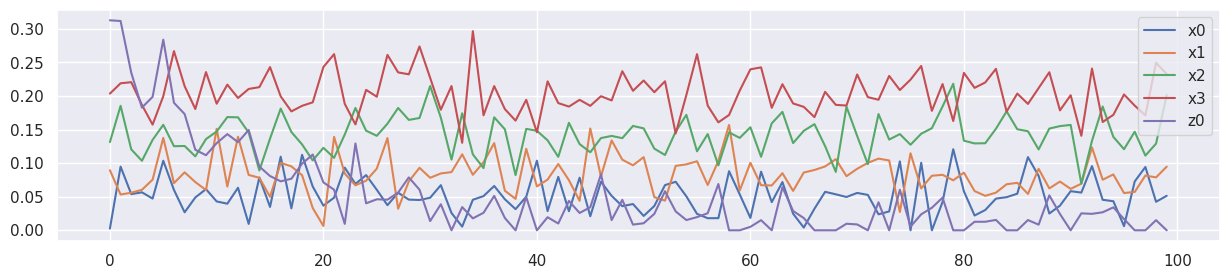

Bucket size 200


100%|██████████| 200/200 [00:01<00:00, 104.68it/s]


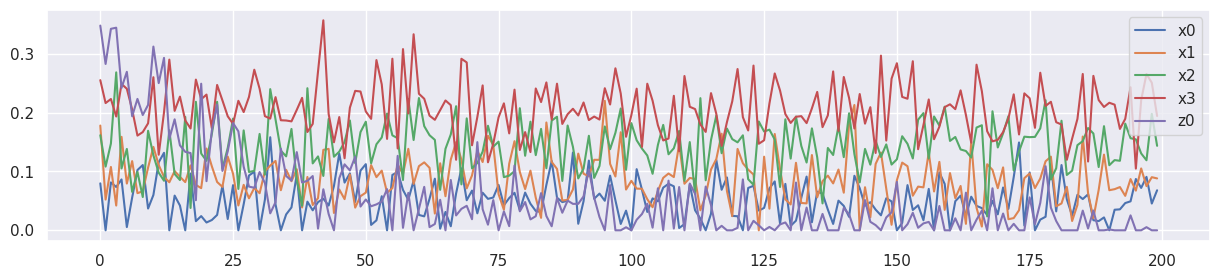

In [69]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 124.60it/s]


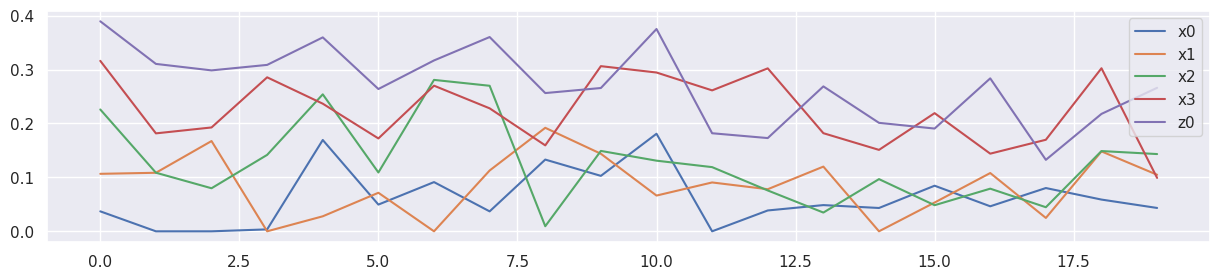

In [70]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 1000/1000 [00:17<00:00, 56.42it/s]


MSE: 0.29
RMSE: 0.54


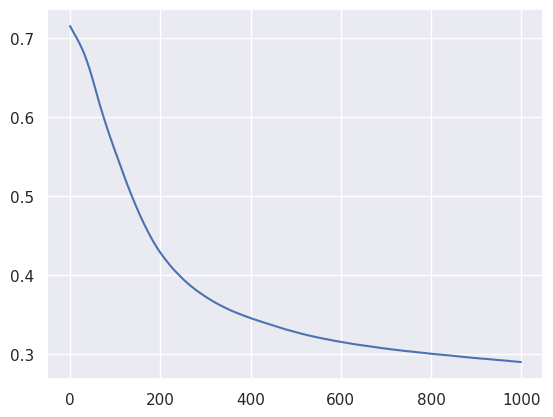

In [71]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ F1 측정

+ 비교 대상의 측정치

In [72]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [73]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8651685393258426


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 634.90it/s]


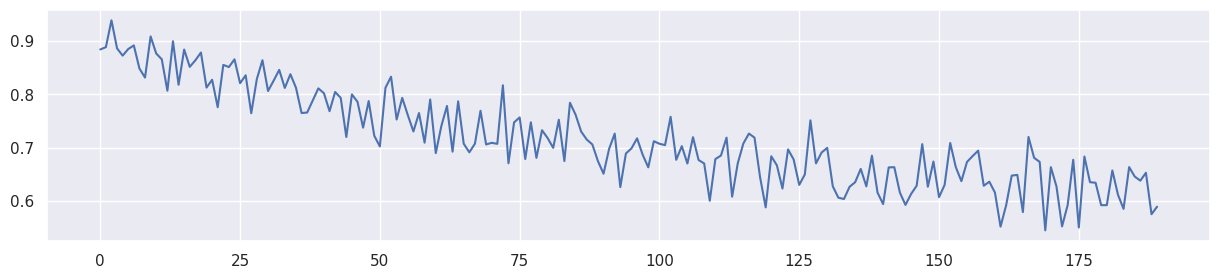

{'lambda': ['Feature 5'], 'test_f1': [0.8651685393258426], 'init_f1': [0.8846153846153846], 'mean_f1': [0.7162507838528116], 'last_f1': [0.5888888888888889], 'MI(y^,z)': [0.2692555625172188]}


In [74]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(pd.DataFrame(X_test[:,4],columns=['z0']), predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)


## feature 5개 + bucket(B) = feature 6개를 학습

In [75]:
# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

100%|██████████| 1000/1000 [00:17<00:00, 57.03it/s]


MSE: 0.27
RMSE: 0.52


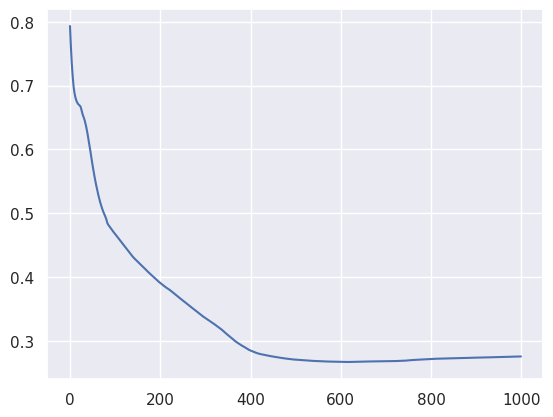

In [76]:
seed_everything()

X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(6, 24),
    nn.ReLU(),
    nn.Linear(24, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [77]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.8536585365853658


100%|██████████| 190/190 [00:00<00:00, 593.31it/s]


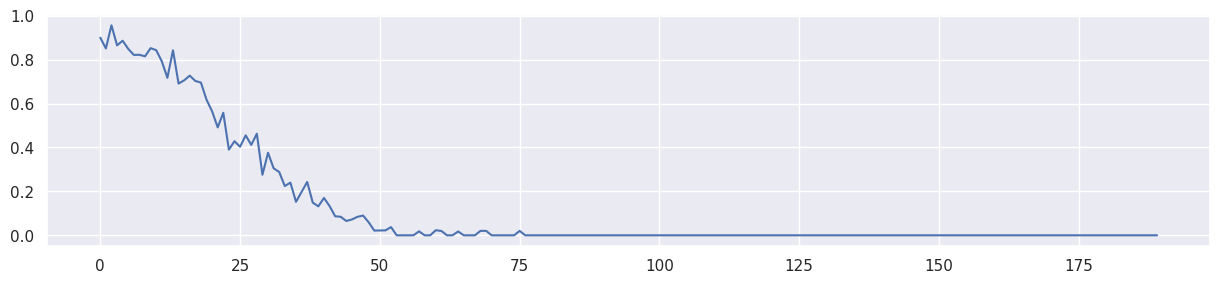

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382

In [78]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(pd.DataFrame(X_test[:,4],columns=['z0']), predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3','z0','b']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 6')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## z0를 빼고, 4개 feature로 학습

100%|██████████| 1000/1000 [00:17<00:00, 57.46it/s]


MSE: 0.13
RMSE: 0.36


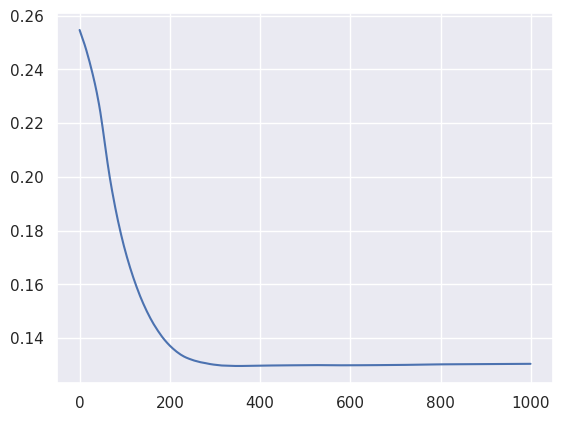

In [79]:
seed_everything()

X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100 # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [80]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.7771428571428571


100%|██████████| 190/190 [00:00<00:00, 645.70it/s]


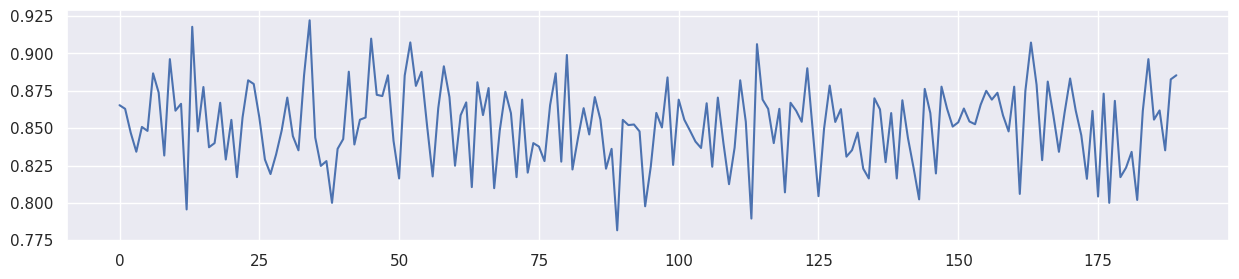

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931

In [81]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(X[1800:2000][['z0']], predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

+ 위에서 보면.... 학습과정에서, 현재는 학습에 효과가 있지만 향후 잠재적으로 성능을 저해할 수 있는 feature를 탐지하여 이의 효과를 경감 또는 (보정) 할 수 있는 학습 방법을 찾아야 하는 것!!!

## RF-Train의 적용

+ 위의 데이터에서, sensitive attribute는 z0에 대당된다.
+ 따라서, MI(y^|z0) = 0 이되어야 하고,
+ Fairness discriminator에서는  Y^과 z0의 loss가 커야 한다! 즉, 최대한 상관 없어야 한다.
+ OK, 일단 이렇게 구성해 본다!

In [82]:
!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 3.58 MiB/s, done.


In [83]:
%cd fr-train
!pwd

/content/fr-train/fr-train
/content/fr-train/fr-train


In [84]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

+ Generator의 구현 = 위에서 feature 5개의 model과 동일
+ DiscriminatorF = Y^과 z0가 같아지지 않게 학습 ??

In [85]:

def test_model(model_, tX, ty, s1):
    """Tests the performance of a model.

    Args:
        model_: A model to test.
        X: Input features of test data.
        y: True label (1-D) of test data.
        s1: Sensitive attribute (1-D) of test data.

    Returns:
        The test accuracy and disparate impact of the model.
    """
    
    model_.eval()
    
    y_hat = model_(tX)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [86]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1),
            nn.Sigmoid()            
        )

    def forward(self, x1, x2):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(torch.cat((x1, x2), 1))
        return predicted_z
    

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF2(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 4),
            nn.Linear(4, 1)       
        )

    def forward(self, x1):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(x1)
        return predicted_z
    

In [87]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    #mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_loss.backward()
        g_losses.append(g_loss)
        optimizer_G.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1, mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1, mi, generator

In [88]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 
        #r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        #f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)

        r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)

        d_f_loss =  (r_loss + f_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [89]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model22(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF2()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 

        # y와 z는 상관관계가 있으므로... r_loss는 최소화 시키고...
        r_loss = mse_loss(discriminator_F(y_train.reshape(-1,1)), s1_train.reshape(-1,1))
        # y^와 z는 최대한 무관하게... f_loss 최대화 시킨다..
        f_loss = mse_loss(discriminator_F(gen_y), s1_train.reshape(-1,1)) * 0.2

        d_f_loss =  (r_loss - f_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [90]:
def test_all_data(generator):

    XT = X[2000:][['x0','x1','x2','x3','z0']]
    yT = y[2000:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
            predicted_y = generator(tmp_x)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 190/190 [00:00<00:00, 644.37it/s]


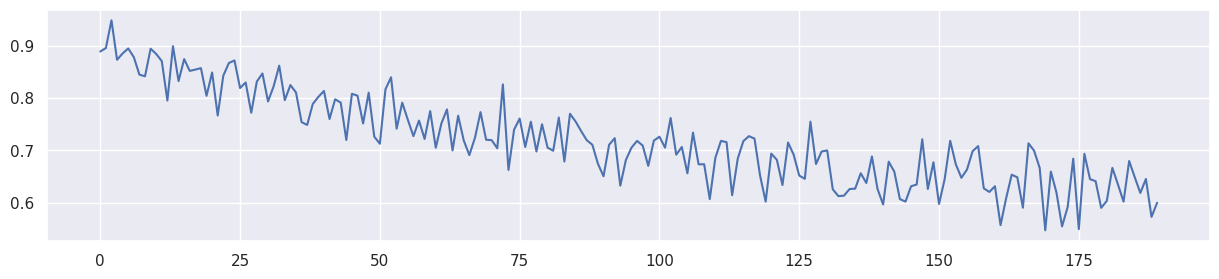

Mean F1 for all data: 0.7198353691465351
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.764362]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 1.385715] [G loss: 0.748424]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 1.379816] [G loss: 0.721642]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 1.369719] [G loss: 0.692447]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 1.361597] [G loss: 0.661667]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 1.359293] [G loss: 0.629466]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 1.361001] [G loss: 0.596741]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 1.364285] [G loss: 0.563744]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 1.368029] [G loss: 0.531376]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 1.371693] [G loss: 0.499893]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 1.375391] [G loss: 0.471104]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 1.378541] [G loss: 0.446025]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 574.13it/s]


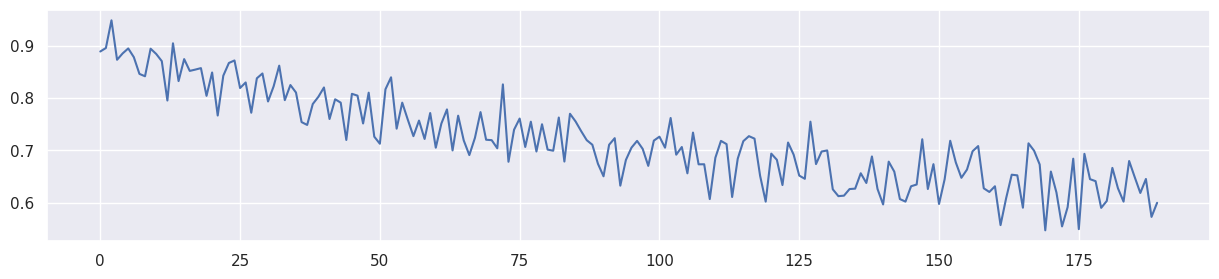

Mean F1 for all data: 0.7199269575388043
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.833470]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 1.385707] [G loss: 0.819187]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 1.379258] [G loss: 0.794397]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 1.366871] [G loss: 0.767057]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 1.356212] [G loss: 0.738834]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 1.352615] [G loss: 0.710249]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 1.354324] [G loss: 0.681624]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 1.358529] [G loss: 0.652855]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 1.363284] [G loss: 0.624683]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 1.367940] [G loss: 0.597247]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 1.372619] [G loss: 0.572237]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 1.376532] [G loss: 0.550378]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 601.02it/s]


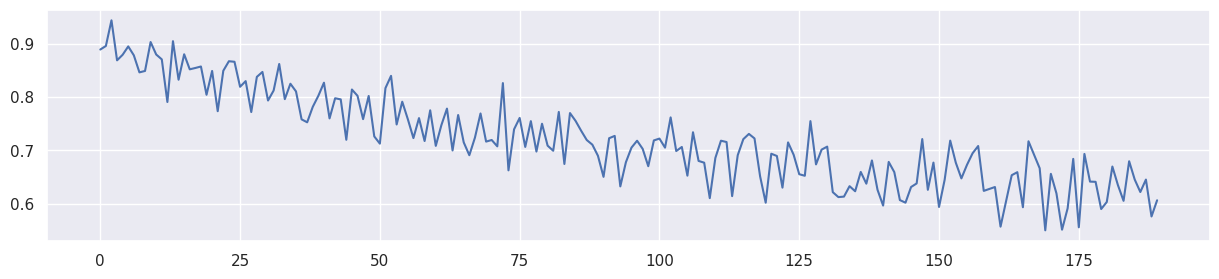

Mean F1 for all data: 0.7205583873659183
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.902577]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 1.385694] [G loss: 0.889952]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 1.378446] [G loss: 0.867016]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 1.362389] [G loss: 0.841007]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 1.346843] [G loss: 0.814998]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 1.340973] [G loss: 0.789855]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 1.342740] [G loss: 0.765414]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 1.347964] [G loss: 0.741051]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 1.354569] [G loss: 0.717223]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 1.361214] [G loss: 0.694206]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 1.367934] [G loss: 0.672915]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 1.373049] [G loss: 0.654381]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 628.51it/s]


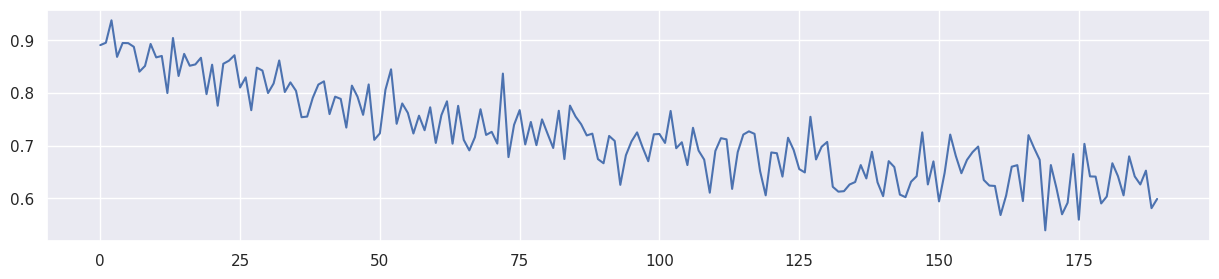

Mean F1 for all data: 0.7214164780211789
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.971684]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 1.385651] [G loss: 0.960716]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 1.377058] [G loss: 0.939390]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 1.354234] [G loss: 0.913654]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 1.329525] [G loss: 0.888927]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 1.318446] [G loss: 0.867105]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 1.319638] [G loss: 0.847040]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 1.326620] [G loss: 0.827323]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 1.335311] [G loss: 0.808170]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 1.345255] [G loss: 0.790189]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 1.355975] [G loss: 0.773466]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 1.364482] [G loss: 0.758701]
[Lambda: 0.400000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 610.38it/s]


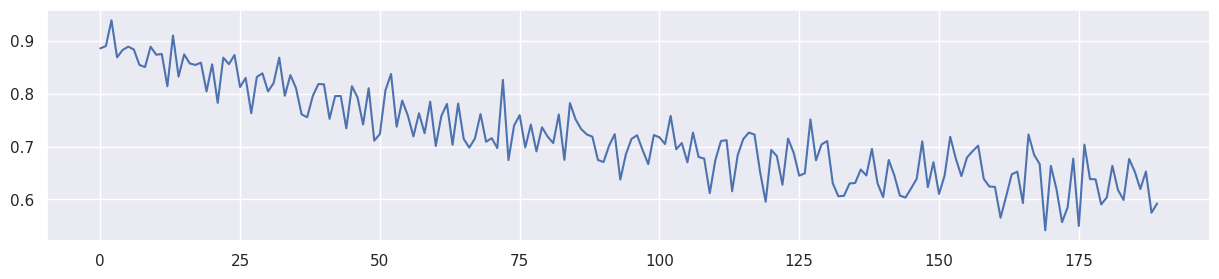

Mean F1 for all data: 0.7198584924509955
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.040792]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 1.385086] [G loss: 1.031416]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 1.365266] [G loss: 1.010256]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 1.314786] [G loss: 0.982919]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 1.272525] [G loss: 0.960884]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 1.258224] [G loss: 0.943746]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 1.258621] [G loss: 0.928428]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 1.265445] [G loss: 0.913316]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 1.274780] [G loss: 0.899293]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 1.288391] [G loss: 0.886958]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 1.305207] [G loss: 0.875826]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 1.322714] [G loss: 0.865882]
[Lambda: 0.500000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 624.37it/s]


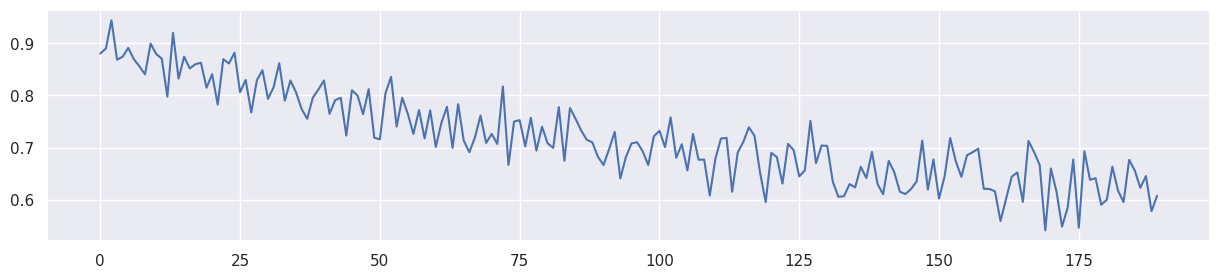

Mean F1 for all data: 0.7197188448434082
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.109899]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 1.384624] [G loss: 1.101906]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 1.359386] [G loss: 1.078351]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 1.286432] [G loss: 1.040596]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 1.209703] [G loss: 1.013609]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 1.178470] [G loss: 1.000641]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 1.171644] [G loss: 0.989958]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 1.170898] [G loss: 0.979577]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 1.171883] [G loss: 0.970392]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 1.174362] [G loss: 0.963220]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 1.180557] [G loss: 0.957649]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 1.187429] [G loss: 0.953300]
[Lambda: 0.600000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 609.73it/s]


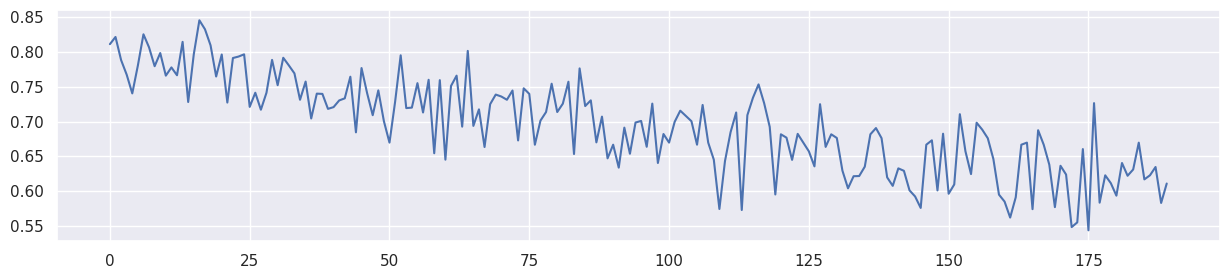

Mean F1 for all data: 0.6939367752835043
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.179006]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 1.384364] [G loss: 1.172318]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 1.352243] [G loss: 1.144222]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 1.258360] [G loss: 1.089529]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 1.159981] [G loss: 1.048331]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 1.106517] [G loss: 1.033059]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 1.087656] [G loss: 1.025751]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 1.081852] [G loss: 1.018620]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 1.079079] [G loss: 1.012759]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 1.078945] [G loss: 1.008387]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 1.079956] [G loss: 1.005195]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 1.082166] [G loss: 1.002947]
[Lambda: 0.700000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 588.02it/s]


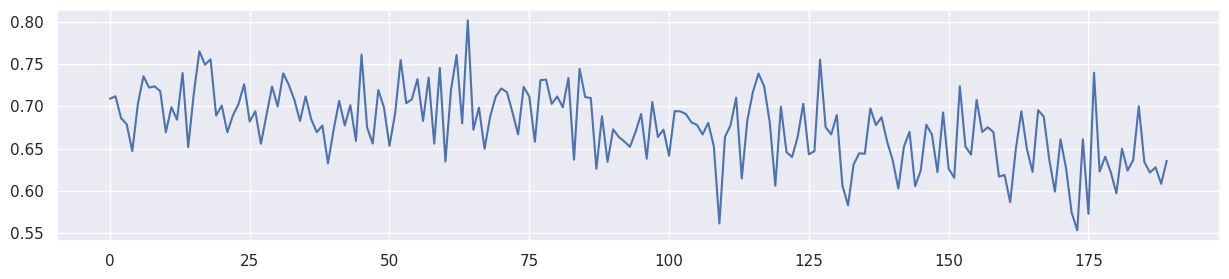

Mean F1 for all data: 0.6760568804559415
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.248114]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 1.383965] [G loss: 1.242565]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 1.342603] [G loss: 1.206555]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 1.228619] [G loss: 1.127630]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 1.110432] [G loss: 1.062805]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 1.041893] [G loss: 1.037911]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 1.013065] [G loss: 1.031554]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 1.004443] [G loss: 1.028972]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 1.003139] [G loss: 1.026490]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 1.004280] [G loss: 1.024115]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 1.005393] [G loss: 1.021932]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 1.006181] [G loss: 1.019991]
[Lambda: 0.800000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 609.41it/s]


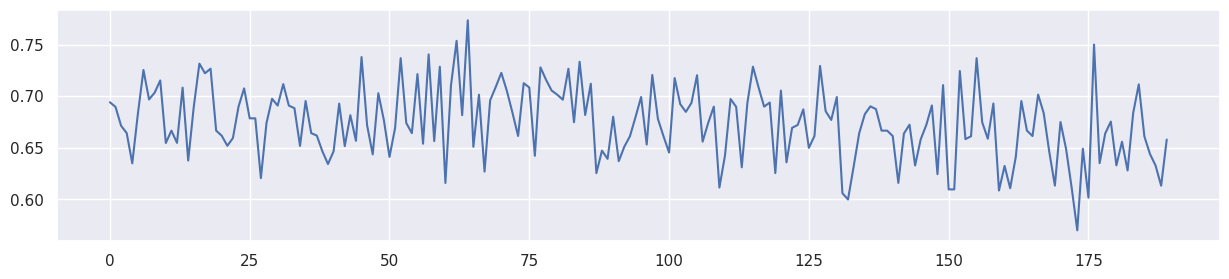

Mean F1 for all data: 0.673983395862796
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.317221]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 1.383212] [G loss: 1.312479]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 1.329523] [G loss: 1.263401]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 1.193672] [G loss: 1.150553]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 1.067594] [G loss: 1.057277]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 0.996381] [G loss: 1.015475]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 0.963313] [G loss: 1.003051]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 0.951129] [G loss: 1.000448]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 0.947176] [G loss: 0.999522]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 0.946042] [G loss: 0.998793]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 0.945847] [G loss: 0.998031]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: 0.945854] [G loss: 0.997296]
[Lambda: 0.900000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 614.67it/s]


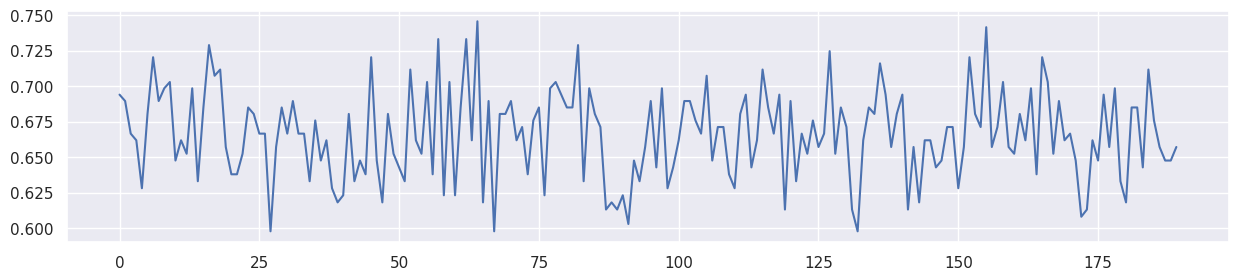

Mean F1 for all data: 0.6660083586974344


lambda   test_f1   init_f1   mean_f1   last_f1      MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  2.692556e-01
1  Feature 6  0.853659  0.900000  0.125232  0.000000  2.003818e-01
2  Feature 4  0.777143  0.865385  0.852120  0.885417  8.693086e-02
0        0.0  0.875000  0.888889  0.719835  0.600000  2.616669e-01
1        0.1  0.875000  0.888889  0.719927  0.600000  2.616669e-01
2        0.2  0.881356  0.888889  0.720558  0.606742  2.598196e-01
3        0.3  0.868571  0.890995  0.721416  0.598870  2.455515e-01
4        0.4  0.865169  0.885714  0.719858  0.592179  2.771431e-01
5        0.5  0.876404  0.880383  0.719719  0.607735  2.707110e-01
6        0.6  0.744589  0.811245  0.693937  0.610837  2.988178e-01
7        0.7  0.614286  0.708772  0.676057  0.635514  7.143892e-02
8        0.8  0.601399  0.694158  0.673983  0.658009  8.881784e-16
9        0.9  0.601399  0.694158  0.666008  0.657244  8.881784e-16

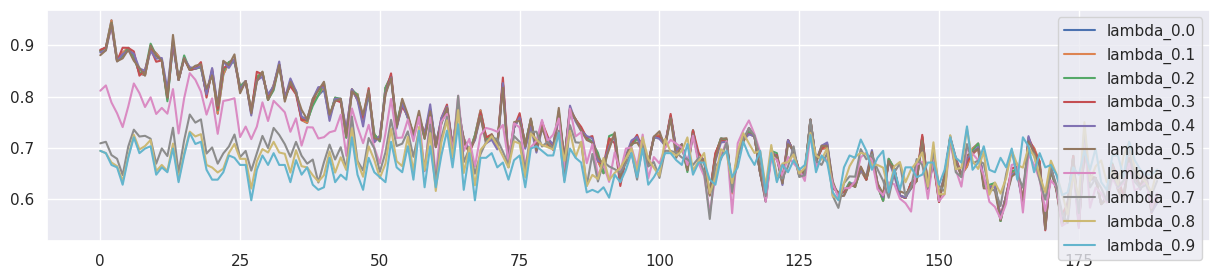

In [91]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)

result3_df = pd.DataFrame(result_table3)


pd.concat([result3_df, result2_df])


[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 190/190 [00:00<00:00, 559.95it/s]


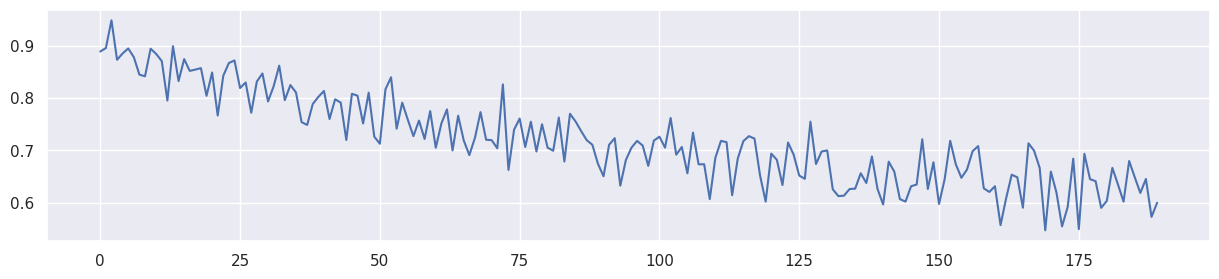

Mean F1 for all data: 0.7198353691465351
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 0.862076]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 0.968830] [G loss: 0.706871]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 0.273386] [G loss: 0.611551]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 0.252632] [G loss: 0.581231]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 0.256065] [G loss: 0.551309]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 0.260366] [G loss: 0.519490]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 0.265285] [G loss: 0.486915]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 0.270510] [G loss: 0.454209]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 0.276017] [G loss: 0.421945]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 0.281302] [G loss: 0.390681]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 0.285962] [G loss: 0.361675]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 0.289781] [G loss: 0.336758]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 623.00it/s]


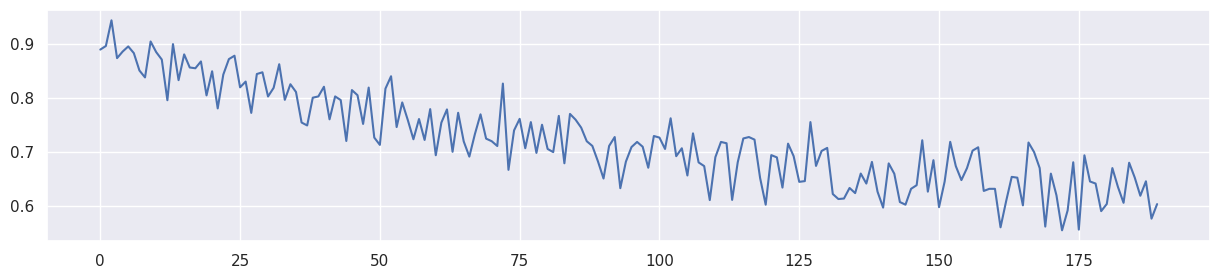

Mean F1 for all data: 0.7213612454075012
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.028898]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 0.968792] [G loss: 0.736075]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 0.273327] [G loss: 0.574269]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 0.252572] [G loss: 0.544917]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 0.255969] [G loss: 0.518645]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 0.260171] [G loss: 0.490850]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 0.264937] [G loss: 0.462475]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 0.269958] [G loss: 0.433995]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 0.275232] [G loss: 0.406071]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 0.280459] [G loss: 0.378775]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 0.285112] [G loss: 0.353456]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 0.289095] [G loss: 0.331553]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 600.49it/s]


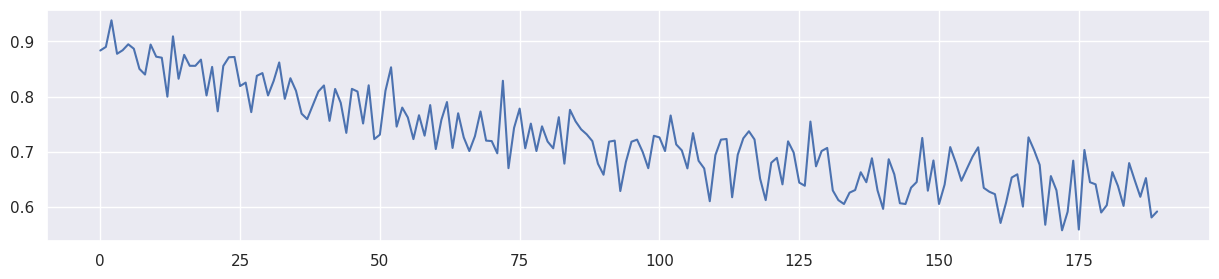

Mean F1 for all data: 0.723196635356523
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.195719]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 0.968739] [G loss: 0.765265]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 0.273249] [G loss: 0.536961]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 0.252503] [G loss: 0.508565]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 0.255848] [G loss: 0.485936]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 0.259898] [G loss: 0.462155]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 0.264434] [G loss: 0.437936]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 0.269307] [G loss: 0.413639]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 0.274241] [G loss: 0.390051]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 0.279310] [G loss: 0.366797]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 0.284012] [G loss: 0.345213]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 0.288001] [G loss: 0.326302]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 593.27it/s]


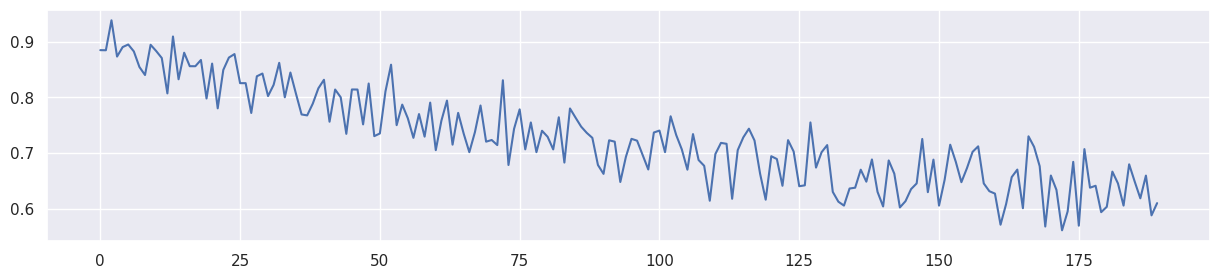

Mean F1 for all data: 0.726365462679275
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.362541]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 0.968660] [G loss: 0.794439]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 0.273139] [G loss: 0.499645]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 0.252415] [G loss: 0.472193]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 0.255666] [G loss: 0.453185]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 0.259522] [G loss: 0.433394]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 0.263784] [G loss: 0.413326]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 0.268332] [G loss: 0.393229]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 0.272863] [G loss: 0.373819]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 0.277819] [G loss: 0.354693]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 0.282457] [G loss: 0.337006]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 0.286635] [G loss: 0.321065]
[Lambda: 0.400000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 626.62it/s]


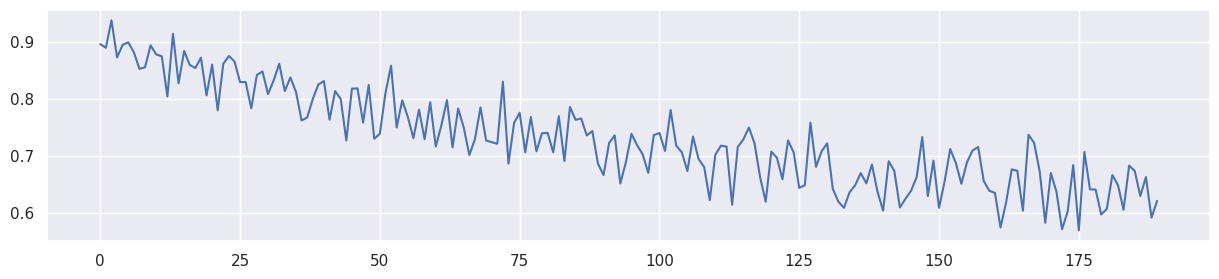

Mean F1 for all data: 0.730987492032082
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.529362]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 0.968542] [G loss: 0.823586]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 0.272976] [G loss: 0.462309]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 0.252289] [G loss: 0.435799]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 0.255411] [G loss: 0.420410]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 0.258978] [G loss: 0.404548]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 0.262769] [G loss: 0.388494]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 0.266930] [G loss: 0.372646]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 0.271060] [G loss: 0.357261]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 0.275456] [G loss: 0.342367]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 0.279962] [G loss: 0.328643]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 0.284234] [G loss: 0.315867]
[Lambda: 0.500000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 581.74it/s]


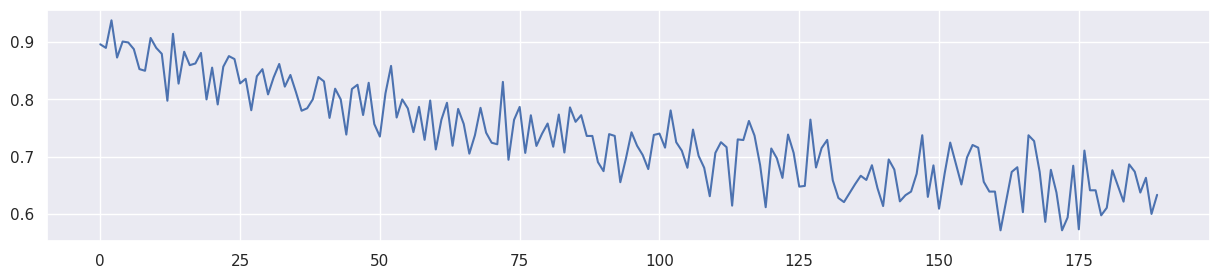

Mean F1 for all data: 0.7351985506205282
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.696184]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 0.968353] [G loss: 0.852679]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 0.272688] [G loss: 0.424955]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 0.252071] [G loss: 0.399419]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 0.254940] [G loss: 0.387646]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 0.258030] [G loss: 0.375603]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 0.261150] [G loss: 0.363514]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 0.264466] [G loss: 0.351776]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 0.268125] [G loss: 0.340468]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 0.271854] [G loss: 0.329673]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 0.275803] [G loss: 0.319933]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 0.279755] [G loss: 0.310934]
[Lambda: 0.600000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 593.55it/s]


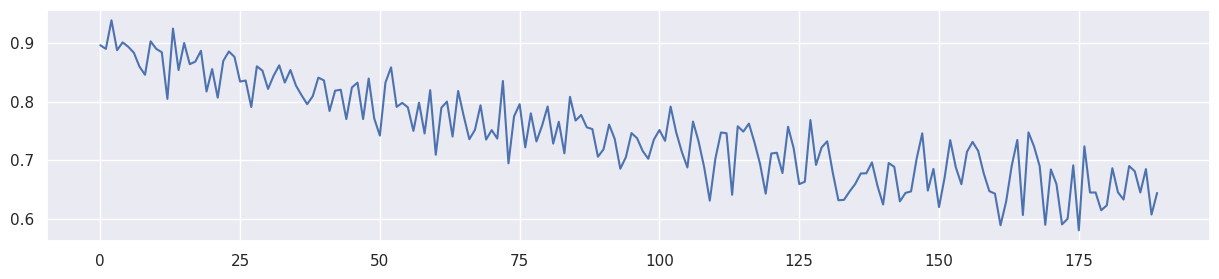

Mean F1 for all data: 0.7460614847368725
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.863006]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 0.967984] [G loss: 0.881664]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 0.272091] [G loss: 0.387593]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 0.251562] [G loss: 0.363131]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 0.253895] [G loss: 0.354877]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 0.256094] [G loss: 0.346412]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 0.258103] [G loss: 0.337942]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 0.259972] [G loss: 0.329880]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 0.261820] [G loss: 0.322257]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 0.264060] [G loss: 0.315496]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 0.267047] [G loss: 0.309579]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 0.271011] [G loss: 0.304191]
[Lambda: 0.700000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 630.75it/s]


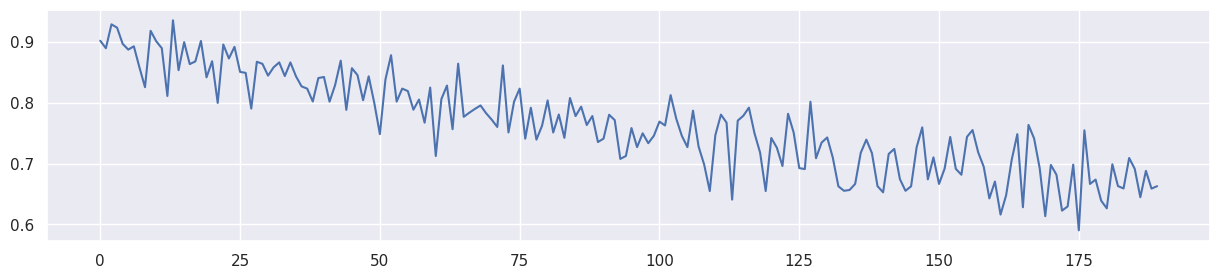

Mean F1 for all data: 0.7643325303860706
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 2.029827]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 0.967109] [G loss: 0.910310]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 0.270296] [G loss: 0.350134]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 0.249830] [G loss: 0.327001]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 0.250636] [G loss: 0.321793]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 0.250575] [G loss: 0.316270]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 0.249552] [G loss: 0.310631]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 0.247460] [G loss: 0.305110]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 0.245454] [G loss: 0.300281]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 0.244539] [G loss: 0.296615]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 0.244849] [G loss: 0.294029]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 0.246501] [G loss: 0.292186]
[Lambda: 0.800000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 616.46it/s]


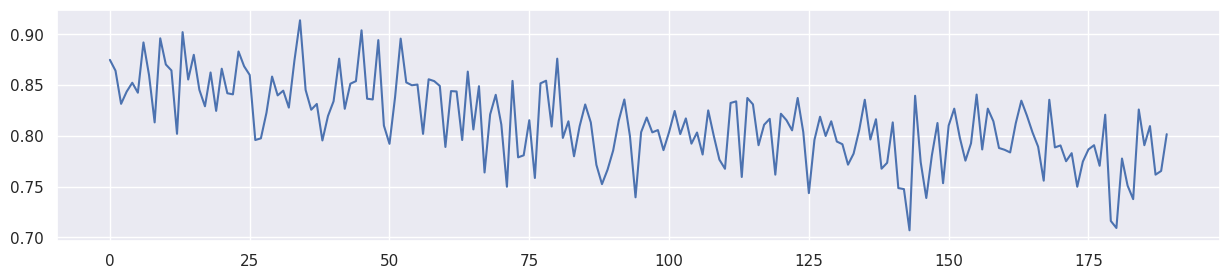

Mean F1 for all data: 0.8135036169680787
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 2.196649]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 0.965095] [G loss: 0.937745]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 0.265343] [G loss: 0.309423]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 0.241610] [G loss: 0.287854]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 0.238901] [G loss: 0.284609]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 0.233094] [G loss: 0.278985]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 0.221551] [G loss: 0.270723]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 0.205555] [G loss: 0.261961]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 0.189516] [G loss: 0.254581]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 0.176448] [G loss: 0.249856]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 0.167626] [G loss: 0.247223]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: 0.161863] [G loss: 0.245589]
[Lambda: 0.900000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 634.33it/s]


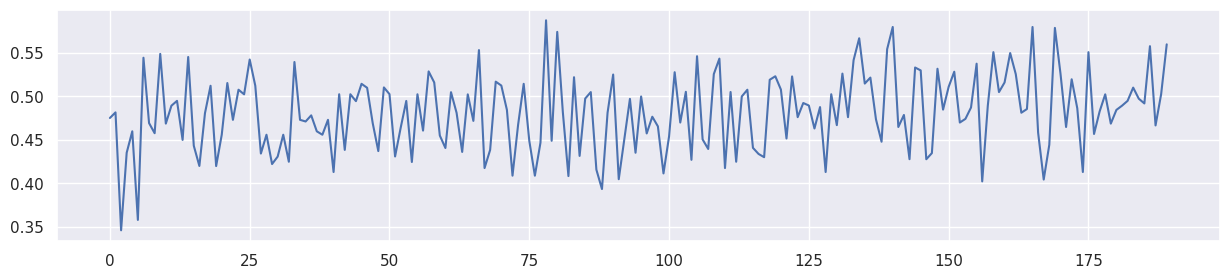

Mean F1 for all data: 0.481489031708359


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.888889  0.721361  0.603352  0.259820
2        0.2  0.868571  0.883495  0.723197  0.592179  0.245552
3        0.3  0.868571  0.884615  0.726365  0.610169  0.245552
4        0.4  0.868571  0.896226  0.730987  0.621469  0.245552
5        0.5  0.875000  0.896226  0.735199  0.633333  0.243805
6        0.6  0.870056  0.896226  0.746061  0.644068  0.228285
7        0.7  0.868571  0.902326  0.764333  0.662983  0.230407
8        0.8  0.791209  0.875000  0.813504  0.801802  0.100854
9        0.9  0.435233  0.475248  0.481489  0.560000  0.265575

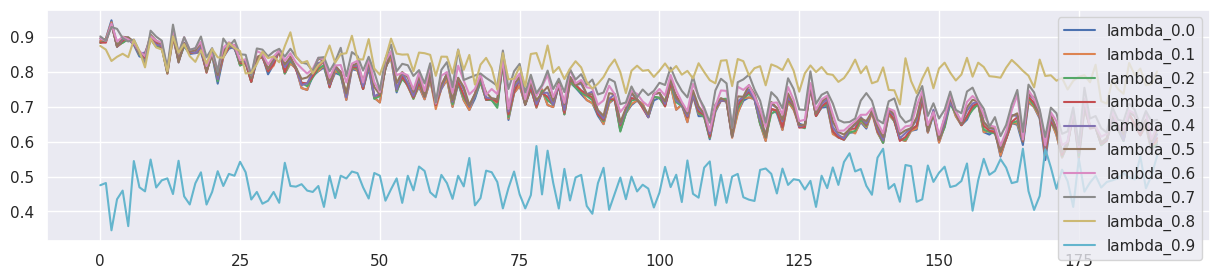

In [92]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model22(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)

result3_df = pd.DataFrame(result_table3)


pd.concat([result3_df, result2_df])


## MINE를 통해 I(y^,z) 측정

(40000, 5)
(40000,)


100%|██████████| 300/300 [00:00<00:00, 622.21it/s]

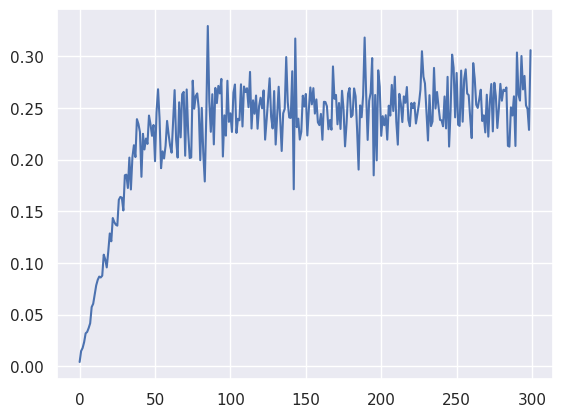

In [93]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 1000

x1 = X[0:1800][['z0']].values
y1 = y_train.data.numpy()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(x.shape)
print(y.shape)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x1.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x1[s].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y1[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1[s])).type(torch.FloatTensor), requires_grad = True)    
    ret = torch.mean(model(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model(x_sample, y_shuffle))))
    loss = - ret  # maximize
    model.zero_grad()
    loss.backward()
    optimizer.step()
    plot_loss.append(ret.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss)

In [94]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine = Net()
    optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        #y1 = gen_y[s].data.numpy()
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = torch.abs(ret)  # maximize

        #mi_loss = mse_loss(torch.mean(mine(x_sample, y_sample)), torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle)))))
        #mi_loss = mse_loss(mine(x_sample, y_sample), mine(x_sample, y_shuffle))

        mine.zero_grad()
        #loss.backward()
        mi_losses.append(mi_loss)
        #optimizer_D_F.step()
        '''
        if epoch > int(n_epochs* lambda_f):
            optimizer_G.zero_grad()
            loss = (1-lambda_f) * g_loss * 0.1  + lambda_f * mi_loss 
            #loss = 0 * g_loss + lambda_f * mi_loss 
            loss.backward()
            optimizer_G.step()

        else:
            mi_loss.backward()
        '''
        optimizer_G.zero_grad()
        loss = (1-lambda_f) * g_loss   + lambda_f * (mi_loss * 1000) 
        #loss = 0 * g_loss + lambda_f * mi_loss 
        loss.backward()
        optimizer_G.step()
        
        optimizer.step()            


        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 190/190 [00:00<00:00, 649.88it/s]


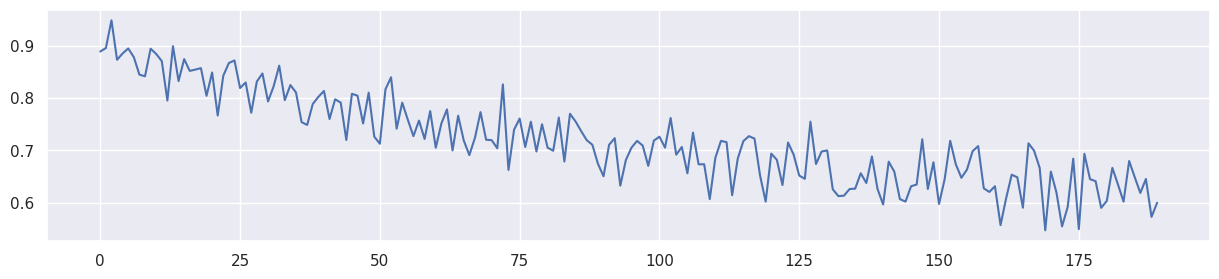

Mean F1 for all data: 0.7198353691465351
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.001382] [G loss: 0.695255]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.000010] [G loss: 0.690334]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.000005] [G loss: 0.679383]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.000002] [G loss: 0.657220]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.000165] [G loss: 0.632453]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.000012] [G loss: 0.604140]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.000028] [G loss: 0.571912]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.000010] [G loss: 0.537440]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.000009] [G loss: 0.502171]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.000027] [G loss: 0.466058]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.000015] [G loss: 0.430721]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.000007] [G loss: 0.396640]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0.00001

100%|██████████| 190/190 [00:00<00:00, 572.99it/s]


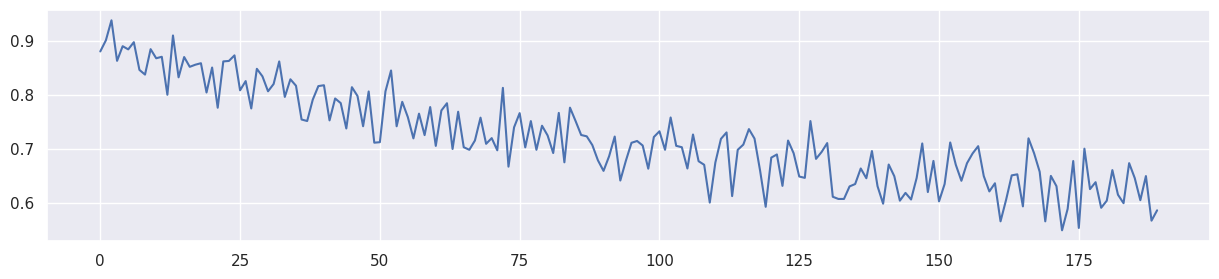

Mean F1 for all data: 0.7189177070782169
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.001319] [G loss: 0.695255]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.000010] [G loss: 0.693658]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.000021] [G loss: 0.689249]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.000008] [G loss: 0.681604]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.000069] [G loss: 0.668535]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.000002] [G loss: 0.653010]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.000017] [G loss: 0.634499]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.000004] [G loss: 0.610496]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.000006] [G loss: 0.581540]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.000046] [G loss: 0.549531]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.000004] [G loss: 0.517180]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.000042] [G loss: 0.483683]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 190/190 [00:00<00:00, 513.79it/s]


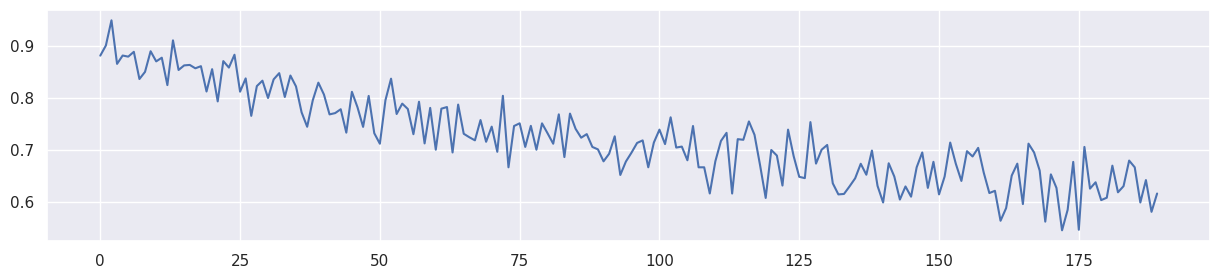

Mean F1 for all data: 0.7233956232285553
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.001269] [G loss: 0.695255]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.000017] [G loss: 0.694429]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.000016] [G loss: 0.693279]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.000003] [G loss: 0.689851]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.000033] [G loss: 0.687518]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.000002] [G loss: 0.682865]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.000011] [G loss: 0.674149]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.000014] [G loss: 0.663494]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.000029] [G loss: 0.649282]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.000002] [G loss: 0.632431]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.000002] [G loss: 0.612124]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.000006] [G loss: 0.587677]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 0.00001

100%|██████████| 190/190 [00:00<00:00, 647.84it/s]


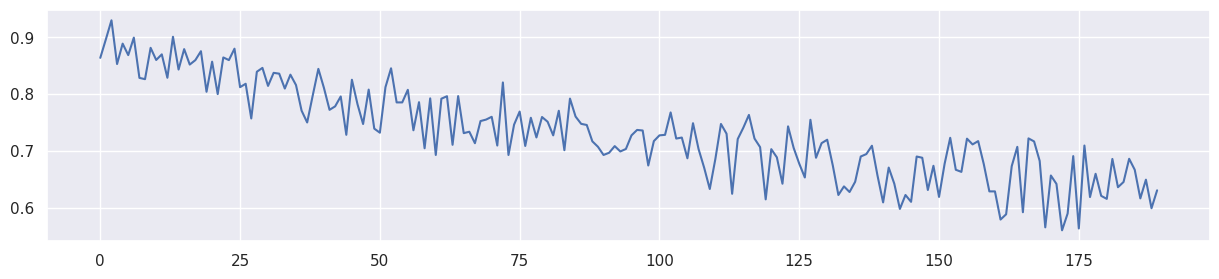

Mean F1 for all data: 0.7315994375110273
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.001424] [G loss: 0.695255]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.000215] [G loss: 0.694740]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.000029] [G loss: 0.694059]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.000018] [G loss: 0.692535]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.000019] [G loss: 0.689674]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.000005] [G loss: 0.688165]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.000004] [G loss: 0.683741]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.000036] [G loss: 0.677924]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.000007] [G loss: 0.671604]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.000001] [G loss: 0.662657]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.000003] [G loss: 0.651120]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.000012] [G loss: 0.638011]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.00002

100%|██████████| 190/190 [00:00<00:00, 640.08it/s]


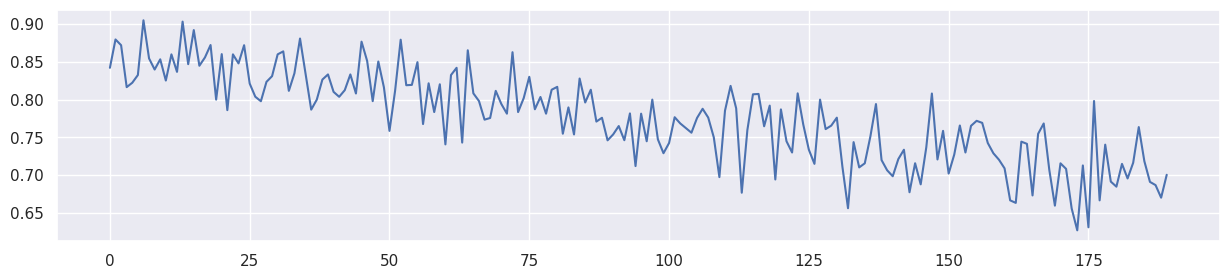

Mean F1 for all data: 0.7761296837173381
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.001455] [G loss: 0.695255]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.000073] [G loss: 0.695005]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.000008] [G loss: 0.694270]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.000015] [G loss: 0.693995]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.000005] [G loss: 0.692222]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.000014] [G loss: 0.689420]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.000002] [G loss: 0.685742]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.000005] [G loss: 0.679810]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.000002] [G loss: 0.672650]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.000012] [G loss: 0.663090]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.000010] [G loss: 0.650979]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.000067] [G loss: 0.636673]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 190/190 [00:00<00:00, 629.60it/s]


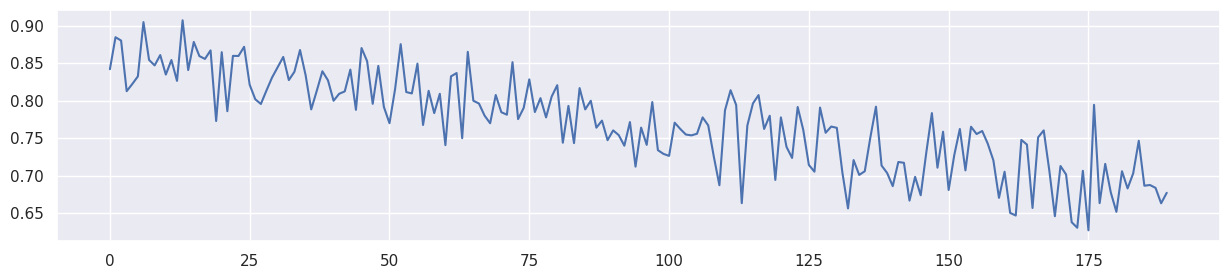

Mean F1 for all data: 0.7702647939643115
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.001429] [G loss: 0.695255]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.000005] [G loss: 0.695211]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000020] [G loss: 0.694588]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.000128] [G loss: 0.694237]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.000006] [G loss: 0.693217]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.000003] [G loss: 0.691246]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.000003] [G loss: 0.689391]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.000013] [G loss: 0.687028]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.000006] [G loss: 0.683353]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.000000] [G loss: 0.679777]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.000006] [G loss: 0.676561]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.000002] [G loss: 0.672366]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 190/190 [00:00<00:00, 600.07it/s]


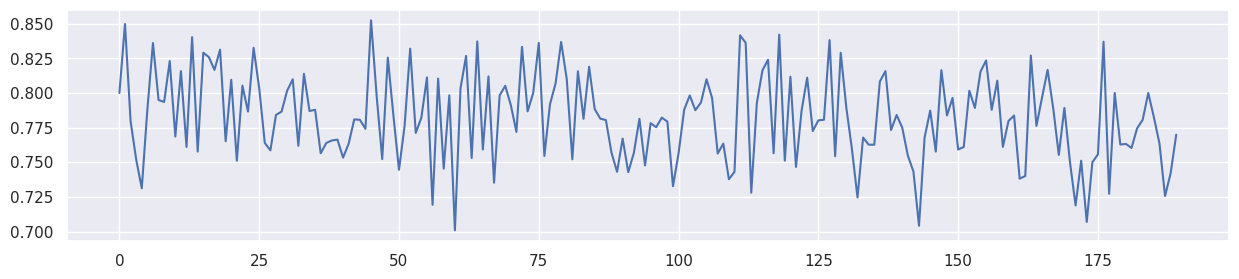

Mean F1 for all data: 0.7821908165793096
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.001458] [G loss: 0.695255]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.000010] [G loss: 0.695013]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000020] [G loss: 0.694769]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000003] [G loss: 0.694367]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000009] [G loss: 0.693828]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000015] [G loss: 0.693079]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.000000] [G loss: 0.691196]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.000003] [G loss: 0.689362]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.000004] [G loss: 0.686561]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.000004] [G loss: 0.681772]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.000011] [G loss: 0.676662]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.000003] [G loss: 0.672204]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0.00004

100%|██████████| 190/190 [00:00<00:00, 569.77it/s]


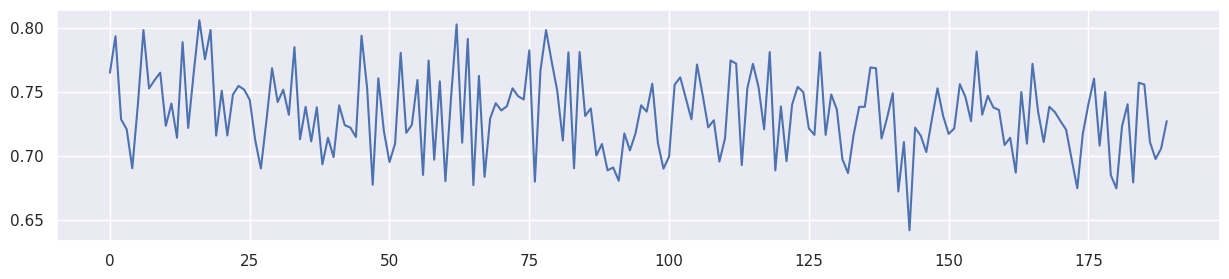

Mean F1 for all data: 0.7327184357878653
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.001429] [G loss: 0.695255]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.000043] [G loss: 0.695260]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000002] [G loss: 0.695046]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000006] [G loss: 0.694836]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000004] [G loss: 0.694473]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000026] [G loss: 0.694224]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000052] [G loss: 0.693528]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000004] [G loss: 0.693063]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000009] [G loss: 0.692699]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000013] [G loss: 0.691341]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000001] [G loss: 0.690499]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000001] [G loss: 0.689991]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 190/190 [00:00<00:00, 623.18it/s]


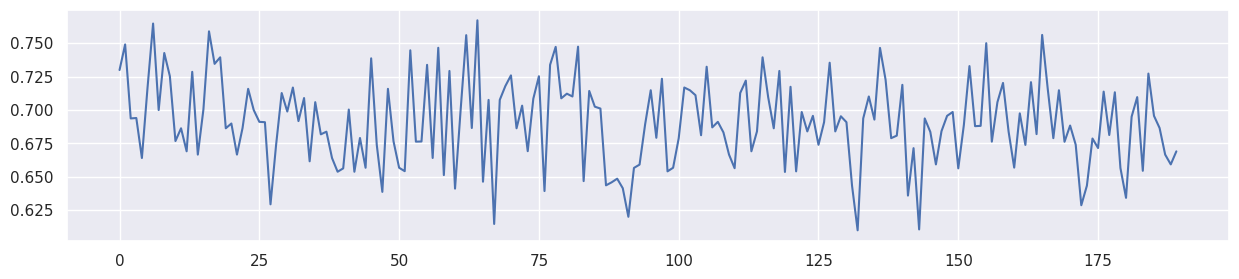

Mean F1 for all data: 0.690667714436064
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.001462] [G loss: 0.695255]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.000037] [G loss: 0.695146]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000002] [G loss: 0.694899]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000029] [G loss: 0.694744]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000027] [G loss: 0.694685]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000021] [G loss: 0.694648]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000044] [G loss: 0.694386]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000015] [G loss: 0.694158]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000011] [G loss: 0.693777]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000010] [G loss: 0.693623]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000002] [G loss: 0.693404]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000001] [G loss: 0.693208]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 0.000006

100%|██████████| 190/190 [00:00<00:00, 647.69it/s]


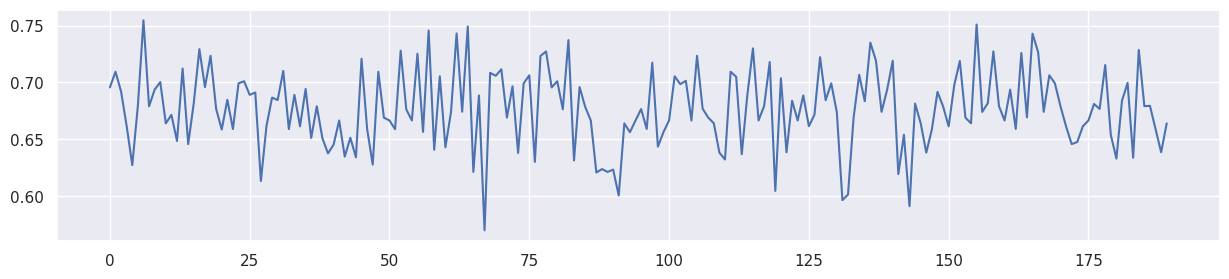

Mean F1 for all data: 0.6769875978295757


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.888889  0.721361  0.603352  0.259820
2        0.2  0.868571  0.883495  0.723197  0.592179  0.245552
3        0.3  0.868571  0.884615  0.726365  0.610169  0.245552
4        0.4  0.868571  0.896226  0.730987  0.621469  0.245552
5        0.5  0.875000  0.896226  0.735199  0.633333  0.243805
6        0.6  0.870056  0.896226  0.746061  0.644068  0.228285
7        0.7  0.868571  0.902326  0.764333  0.662983  0.230407
8        0.8  0.791209  0.875000  0.813504  0.801802  0.100854
9        0.9  0.435233  0.475248  0.481489  0.560000  0.265575
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.880383  0.718918  0.585635  0.258235
2        0.2  0.882682  0.881517  0.723396  0.616216  0.280927
3        0.3  0.864865  0.863850  0.731599  0.630435  0.242123
4        0.4  0.794118  0.842105  0.776130  0.700508  0.093596
5        0.5  0.805970  0.842105  0.770265  0.677083  0.113515
6        0.6  0.700422  0.800000  0.782191  0.769912  0.012120
7        0.7  0.656250  0.765152  0.732718  0.727273  0.001996
8        0.8  0.631970  0.729927  0.690668  0.669091  0.019937
9        0.9  0.639098  0.695652  0.676988  0.664151  0.000000

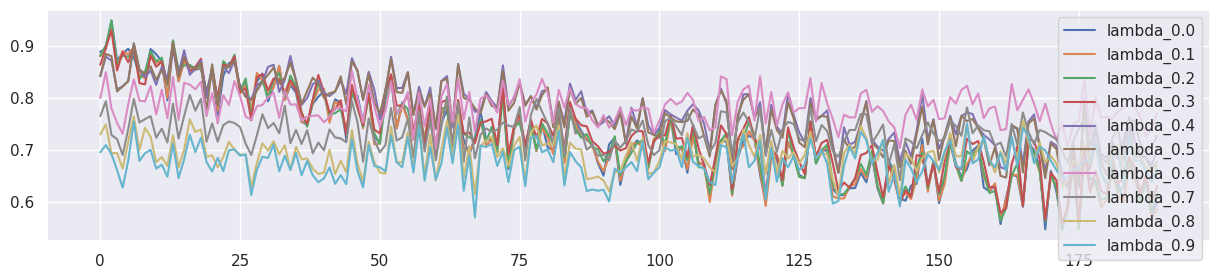

In [95]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]# Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.4,0.8]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



In [96]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model4(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine = Net()
    optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        #y1 = gen_y[s].data.numpy()  # y^의 샘플
        #y2 = y_train[s].data.numpy().reshape(-1,1) # y의 샘플
        #print('y1',y1.shape)
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        y2_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
        y2_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret2(y의 샘플)는 maximize 하야 하고
        # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret2 + torch.abs(ret1)

        #mi_loss = mse_loss(torch.mean(mine(x_sample, y_sample)), torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle)))))
        #mi_loss = mse_loss(mine(x_sample, y_sample), mine(x_sample, y_shuffle))

        mine.zero_grad()
        #loss.backward()
        mi_losses.append(-ret2)
        #optimizer_D_F.step()
        '''
        if epoch > int(n_epochs* lambda_f):
            optimizer_G.zero_grad()
            loss = (1-lambda_f) * g_loss * 0.1  + lambda_f * mi_loss 
            #loss = 0 * g_loss + lambda_f * mi_loss 
            loss.backward()
            optimizer_G.step()

        else:
            mi_loss.backward()
        '''
        optimizer_G.zero_grad()
        loss = (1-lambda_f) * g_loss  + lambda_f * mi_loss
        #loss = 0 * g_loss + lambda_f * mi_loss 
        loss.backward()
        optimizer_G.step()
        
        optimizer.step()            


        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 190/190 [00:00<00:00, 588.36it/s]


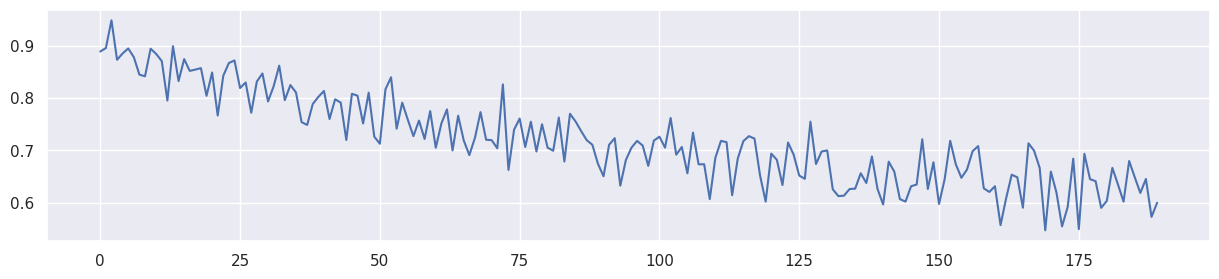

Mean F1 for all data: 0.7198353691465351
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: -0.000739] [G loss: 0.695255]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: -0.222802] [G loss: 0.678150]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: -0.232147] [G loss: 0.650272]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: -0.240700] [G loss: 0.619241]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: -0.263916] [G loss: 0.585774]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: -0.243720] [G loss: 0.550417]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: -0.287932] [G loss: 0.514393]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: -0.233790] [G loss: 0.478189]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: -0.225556] [G loss: 0.442514]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: -0.287643] [G loss: 0.407986]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: -0.255703] [G loss: 0.375675]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: -0.257355] [G loss: 0.347709]
[Lambda: 0.100000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 607.10it/s]


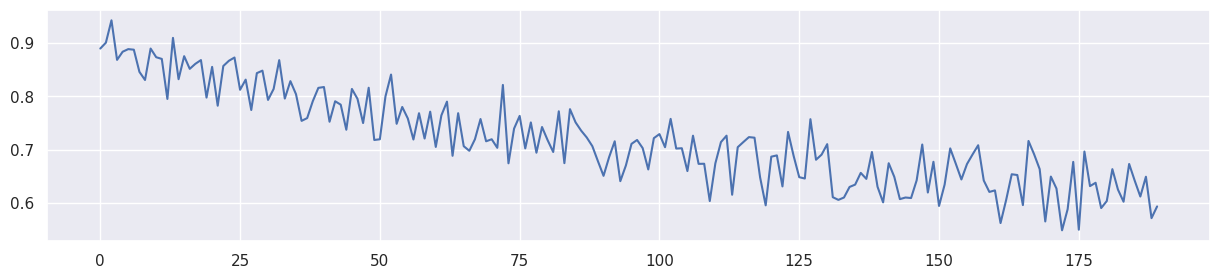

Mean F1 for all data: 0.719376208890677
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: -0.000677] [G loss: 0.695255]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: -0.244941] [G loss: 0.679190]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: -0.279415] [G loss: 0.653083]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: -0.242253] [G loss: 0.623113]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: -0.248699] [G loss: 0.590609]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: -0.280676] [G loss: 0.556493]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: -0.226991] [G loss: 0.521993]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: -0.211785] [G loss: 0.487821]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: -0.210887] [G loss: 0.454136]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: -0.265526] [G loss: 0.421877]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: -0.280317] [G loss: 0.391272]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: -0.242747] [G loss: 0.363413]
[Lambda: 0.200000] [Epoch 2400/4000] [mi lo

100%|██████████| 190/190 [00:00<00:00, 584.95it/s]


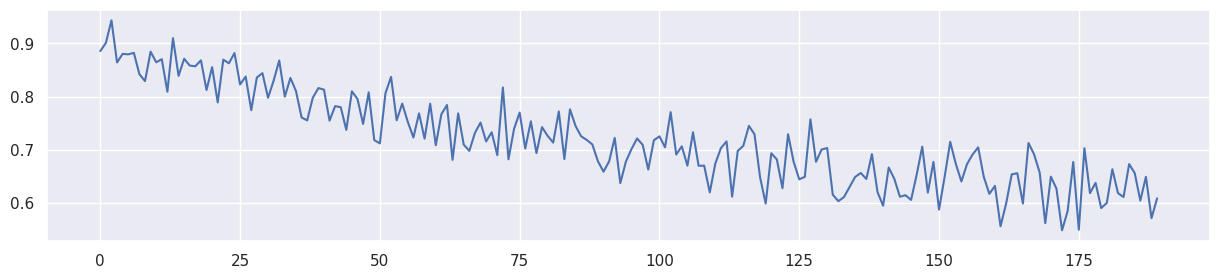

Mean F1 for all data: 0.7199430791688509
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: -0.000742] [G loss: 0.695255]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: -0.245598] [G loss: 0.680824]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: -0.272874] [G loss: 0.657172]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: -0.174749] [G loss: 0.629038]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: -0.279567] [G loss: 0.598375]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: -0.259253] [G loss: 0.566282]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: -0.269198] [G loss: 0.533772]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: -0.299205] [G loss: 0.501723]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: -0.266123] [G loss: 0.470205]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: -0.220784] [G loss: 0.439579]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: -0.188179] [G loss: 0.410173]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: -0.227204] [G loss: 0.383056]
[Lambda: 0.300000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 574.18it/s]


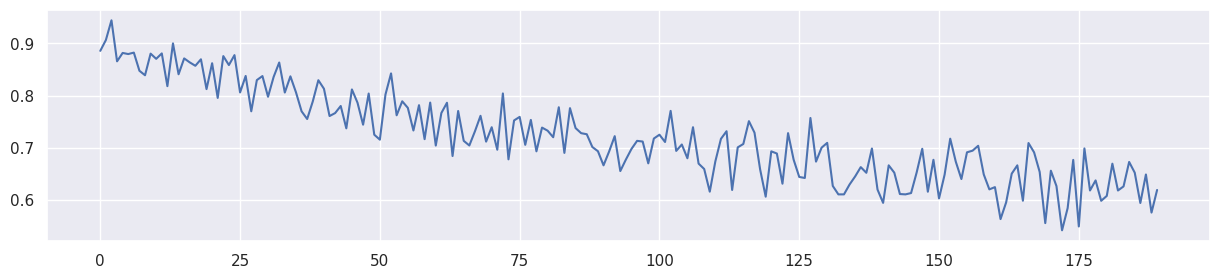

Mean F1 for all data: 0.7218974643206381
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: -0.000893] [G loss: 0.695255]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: -0.275481] [G loss: 0.682181]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: -0.277822] [G loss: 0.663782]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: -0.214287] [G loss: 0.639259]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: -0.207279] [G loss: 0.611411]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: -0.242542] [G loss: 0.581847]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: -0.237985] [G loss: 0.552224]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: -0.269566] [G loss: 0.523299]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: -0.282700] [G loss: 0.494989]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: -0.221186] [G loss: 0.467557]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: -0.233922] [G loss: 0.440869]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: -0.245251] [G loss: 0.415112]
[Lambda: 0.400000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 488.33it/s]


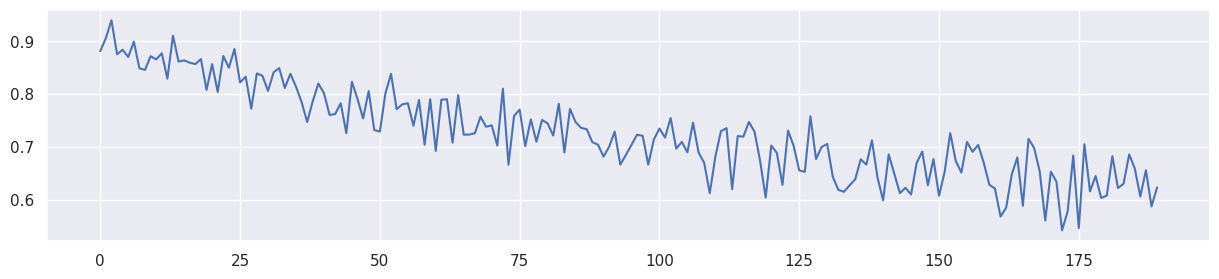

Mean F1 for all data: 0.726376265473773
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: -0.000846] [G loss: 0.695255]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: -0.279178] [G loss: 0.683374]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: -0.259610] [G loss: 0.672332]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: -0.270299] [G loss: 0.654484]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: -0.226075] [G loss: 0.631665]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: -0.270892] [G loss: 0.606831]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: -0.255636] [G loss: 0.581247]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: -0.281424] [G loss: 0.555141]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: -0.268966] [G loss: 0.529909]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: -0.193397] [G loss: 0.505481]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: -0.263192] [G loss: 0.482167]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: -0.246648] [G loss: 0.460059]
[Lambda: 0.500000] [Epoch 2400/4000] [mi lo

100%|██████████| 190/190 [00:00<00:00, 637.67it/s]


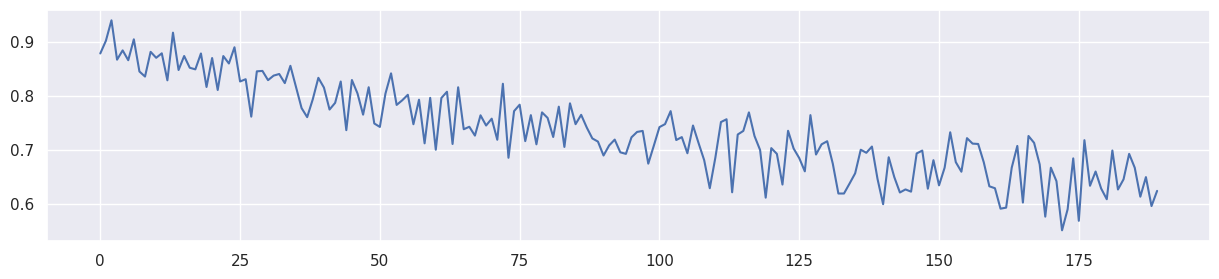

Mean F1 for all data: 0.7353806679408204
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: -0.000558] [G loss: 0.695255]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: -0.234340] [G loss: 0.684056]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: -0.262046] [G loss: 0.676585]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: -0.267551] [G loss: 0.667174]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: -0.271732] [G loss: 0.655400]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: -0.260225] [G loss: 0.639717]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: -0.229275] [G loss: 0.619356]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: -0.300906] [G loss: 0.598720]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: -0.278636] [G loss: 0.577362]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: -0.242171] [G loss: 0.556024]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: -0.307476] [G loss: 0.535980]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: -0.271403] [G loss: 0.516216]
[Lambda: 0.600000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 569.36it/s]


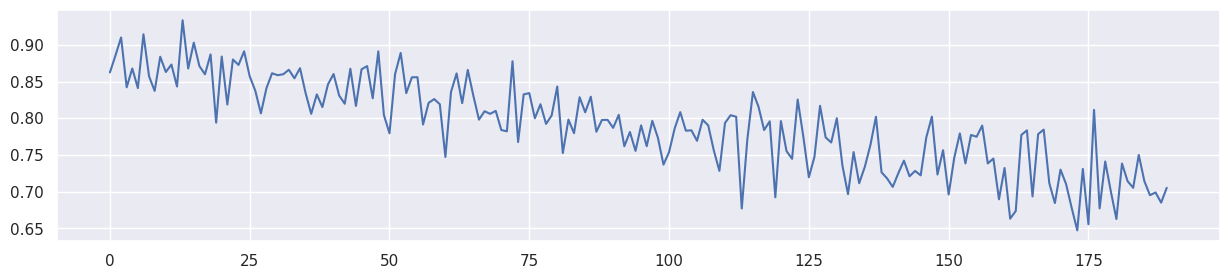

Mean F1 for all data: 0.7906247455124247
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: -0.000891] [G loss: 0.695255]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: -0.269977] [G loss: 0.685160]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: -0.253576] [G loss: 0.680309]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: -0.291978] [G loss: 0.674812]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: -0.264385] [G loss: 0.668287]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: -0.224966] [G loss: 0.660678]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: -0.279648] [G loss: 0.651367]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: -0.232376] [G loss: 0.640140]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: -0.222308] [G loss: 0.627423]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: -0.220864] [G loss: 0.613096]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: -0.305240] [G loss: 0.598121]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: -0.249982] [G loss: 0.582132]
[Lambda: 0.700000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 630.76it/s]


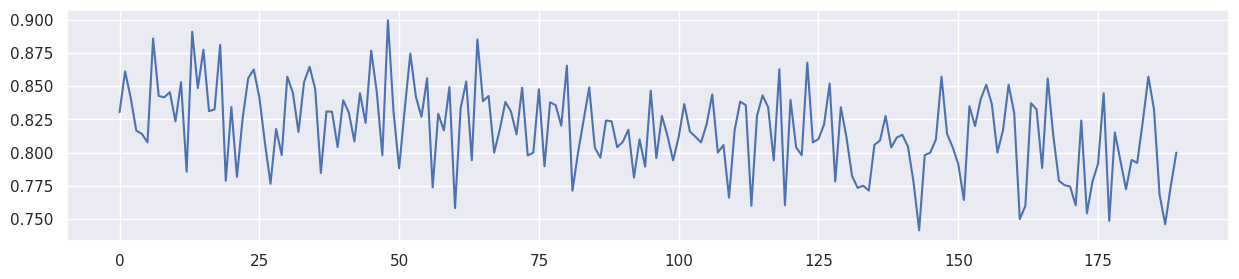

Mean F1 for all data: 0.8174265200121391
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: -0.000439] [G loss: 0.695255]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: -0.287423] [G loss: 0.686275]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: -0.253872] [G loss: 0.683868]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: -0.256503] [G loss: 0.680964]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: -0.237608] [G loss: 0.678448]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: -0.244200] [G loss: 0.675664]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: -0.222225] [G loss: 0.672926]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: -0.254149] [G loss: 0.669163]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: -0.225802] [G loss: 0.665425]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: -0.285171] [G loss: 0.661500]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: -0.313716] [G loss: 0.656346]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: -0.267402] [G loss: 0.650495]
[Lambda: 0.800000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 614.84it/s]


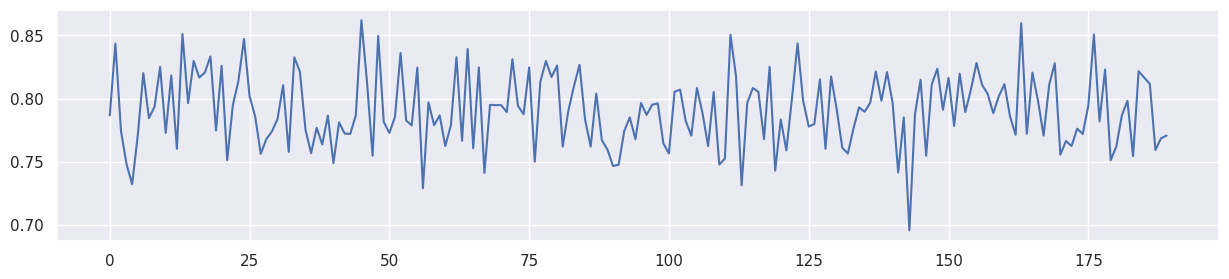

Mean F1 for all data: 0.7906896897282735
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: -0.000790] [G loss: 0.695255]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: -0.240435] [G loss: 0.687188]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: -0.261894] [G loss: 0.686855]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: -0.274611] [G loss: 0.686246]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: -0.221249] [G loss: 0.685538]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: -0.275590] [G loss: 0.685131]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: -0.223747] [G loss: 0.684894]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: -0.264731] [G loss: 0.684445]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: -0.261502] [G loss: 0.684232]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: -0.242553] [G loss: 0.683575]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: -0.238953] [G loss: 0.683112]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: -0.207047] [G loss: 0.682274]
[Lambda: 0.900000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 613.87it/s]


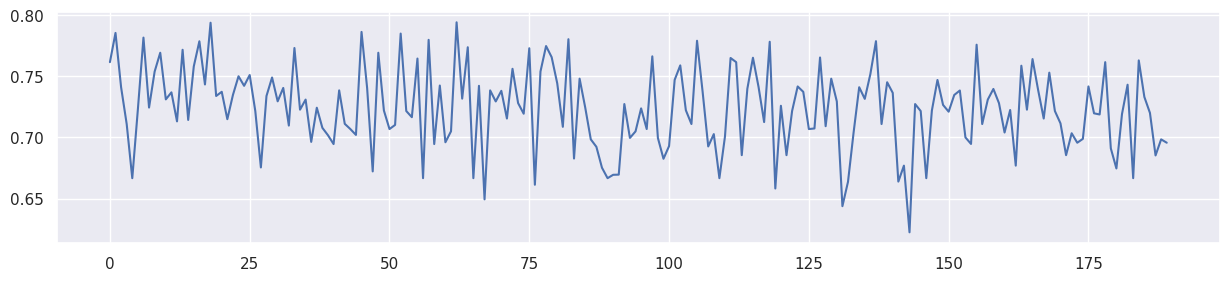

Mean F1 for all data: 0.7237270471055474


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.888889  0.721361  0.603352  0.259820
2        0.2  0.868571  0.883495  0.723197  0.592179  0.245552
3        0.3  0.868571  0.884615  0.726365  0.610169  0.245552
4        0.4  0.868571  0.896226  0.730987  0.621469  0.245552
5        0.5  0.875000  0.896226  0.735199  0.633333  0.243805
6        0.6  0.870056  0.896226  0.746061  0.644068  0.228285
7        0.7  0.868571  0.902326  0.764333  0.662983  0.230407
8        0.8  0.791209  0.875000  0.813504  0.801802  0.100854
9        0.9  0.435233  0.475248  0.481489  0.560000  0.265575
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.868571  0.889952  0.719376  0.593407  0.245552
2        0.2  0.870056  0.885714  0.719943  0.608696  0.272083
3        0.3  0.882682  0.885714  0.721897  0.619565  0.280927
4        0.4  0.877778  0.881517  0.726376  0.623656  0.265105
5        0.5  0.868132  0.878505  0.735381  0.623656  0.261532
6        0.6  0.829787  0.862385  0.790625  0.705263  0.136418
7        0.7  0.778325  0.830357  0.817427  0.800000  0.057065
8        0.8  0.712446  0.786611  0.790690  0.770642  0.022388
9        0.9  0.666667  0.761538  0.723727  0.695652  0.000000

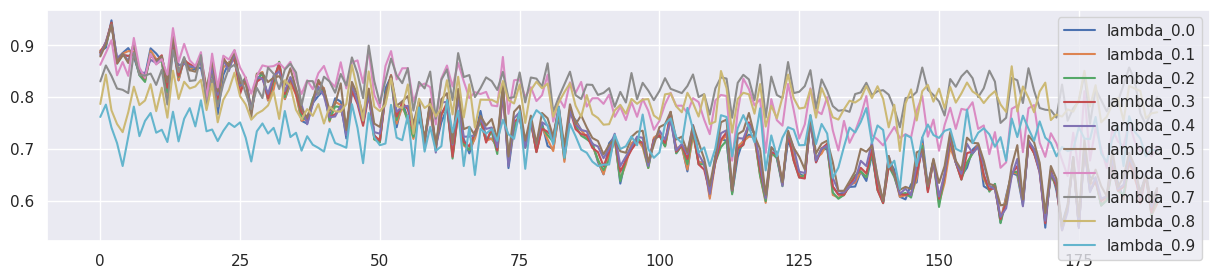

In [97]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]# Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.4,0.8]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model4(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



# GAN 기반의 RF-Train이 아닌, G(Z,B) 모델에서 전처리 학습 방법 적용
+ GAN 기번의 RF-Train 응용 방법은 일종의 orver-fitting을 막는 방법론에 해당한다.
+ 즉, trainset의 z에 over-fitting되어 이후 live data에 대해 성능이 저하되는 현상을 막도록하는 방법이다.
+ 따라서 이 방법은 결정적으로 test_f1 및 init_f1을 낮게 (z를 포함한 모든 feature을 학습하는 일반적인 학습방법에 비하여) 하는 결점을 갖는다.
+ 그렇다면, 이를 극복하며 live data의 성능도 떨어지지 않게 하는 방법은 무엇인가?
+ 본 chapter에서는 G(Z,B)를 입력으로 갖는 구조. 즉, bucket number와 z의 관계를 학습하여 전처리의 개념으로 새로 생성된 g를 z에 대신하여 D(x,g)에 입력하여 학습하는 모델을 제안한다.

## D(x,G(z,b)) 구조


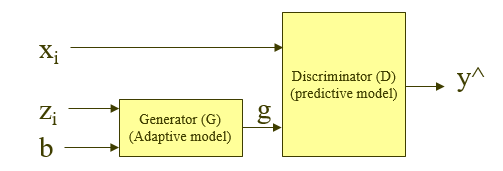

<pre>
x0 -------------------------------------> |                        |
x1 -------------------------------------> |                        |
x2 -------------------------------------> | Discriminator (D(x,g)) | -> y^
x3 -------------------------------------> | predictive model       |
z0 ------>| Generator (G(z,b)) | -- g --> |                        |
b  ------>| adaptive model     |
</pre>

+ 상기 구조의 loss function

$$
L_1 = H(y,\hat{y}) = H(y,D(x,G(z,b)))=\mathbb{E}_{y}[-log(D(x,G(z,b)))]
$$

$$
L_2 = MSE(G(z,b),z)
$$

$$
\min_{G(.)} (1-λ) L_1 + λ L_2
$$


+ 위의 loss function에서, lambda가 0이면 $L_1$의 backward 에서 D를 거쳐 G까지 학습이 이루어 진다. 
+ lambda가 0~1 사이의 값인 경우, G의 생성이 b의 값을 무시하는 방향으로 학습된다. 즉, feature 5개 입력의 특성에 근접, 다시말해 over-fitting의 효과로 학습된다.

In [98]:
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

In [99]:
mi_scores = make_mi_scores(X[['x0','x1','x2','x3','z0']], X['b'], discrete_features="auto")
print(mi_scores)

z0    0.163087
x0    0.000000
x1    0.000000
x2    0.000000
x3    0.000000
Name: MI Scores, dtype: float64


+ I(Z,B) 만 0.16의 수치가 나오는 것을 확인 할 수 있음!!!!
+ 즉, Z는 시간에 따라 importance가 변하고 있음.... -> Concept drift의 발생 요소  

In [100]:
# 학습셋에서의 I(Z,B)

mi_scores = make_mi_scores(X[0:2000][['x0','x1','x2','x3','z0']], X[0:2000]['b'], discrete_features="auto")
print(mi_scores)

x3    0.020639
x2    0.010275
x0    0.000000
x1    0.000000
z0    0.000000
Name: MI Scores, dtype: float64


+ 감지 안됨!!!!

(40000, 5)
(40000,)


100%|██████████| 5000/5000 [00:08<00:00, 607.29it/s]



0.0058872644


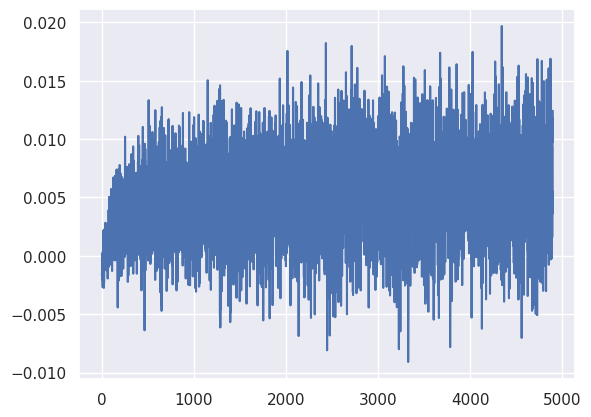

In [101]:
from tqdm import tqdm

H=20
n_epoch = 5000
minibatch = 1000

x1 = X[0:2000][['z0']].values
y1 = X[0:2000][['b']].values #y_train.data.numpy()

#x1 = X[['z0']].values
#y1 = X[['b']].values #y_train.data.numpy()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(x.shape)
print(y.shape)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x1.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x1[s].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y1[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1[s])).type(torch.FloatTensor), requires_grad = True)    
    ret = torch.mean(model(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model(x_sample, y_shuffle))))
    loss = - ret  # maximize
    model.zero_grad()
    loss.backward()
    optimizer.step()
    plot_loss.append(ret.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[100:])
print(np.mean(plot_loss[4000:]))

+ 유의미하게 감지되지 않음.....
+ 잘 안될거 같은데...

In [141]:
avaible_range = 400

In [102]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 15),
            nn.ReLU(),
            nn.Linear(15, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, z0,b):

        adjusted_z = self.model(torch.cat((z0,b), 1))
        return adjusted_z

In [142]:

def test_model2(model_,model2_, tX, ty, s1):
    model_.eval()
    model2_.eval()

    a_z = model2_(tX[:,4].reshape(-1,1),tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(torch.cat((tX[:,0:4],a_z.reshape(-1,1)),1))
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [143]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model5(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter()
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  MINE -> I(Z,B)의 측정
        # -------------------------------
        '''
        s = np.random.choice(XS_train.shape[0],minibatch)

        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = XS_train[s][:,5].reshape(-1,1) # bucket number.. B
        y_shuffle = XS_train[np.random.permutation(s)][:,5].reshape(-1,1) #permute bucket number.. B
        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = - ret1

        ibz = torch.full((XS_train.shape[0],1), ret1.data.numpy())
        '''
        a_z = adapter(XS_train[:,4].reshape(-1,1) ,XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = mse_loss(a_z, XS_train[:,5].reshape(-1,1)) 

        # -------------------
        #  Forwards Generator
        # -------------------
        xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model2(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

In [105]:
def test_all_data3(generator,train_size):

    XT = X[train_size:][['x0','x1','x2','x3','z0']]
    yT = y[train_size:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
            #xs = adapter(tmp_x[:,4].reshape(-1,1),tmp_x[:,5].reshape(-1,1)).reshape(-1,1)
            predicted_y = generator(tmp_x)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [144]:
def test_all_data2(generator,adapter,train_size):

    XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    yT = y[train_size:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
            xs = adapter(tmp_x[:,4].reshape(-1,1),tmp_x[:,5].reshape(-1,1)/avaible_range).reshape(-1,1)
            predicted_y = generator(torch.cat((tmp_x[:,0:4],xs),1))
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 154.037689] [G loss: 0.662213]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 281.415771] [G loss: 0.569898]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 321.137939] [G loss: 0.513112]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 383.931793] [G loss: 0.471092]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 435.589111] [G loss: 0.435976]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 441.561279] [G loss: 0.405468]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 413.537842] [G loss: 0.377526]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 353.051453] [G loss: 0.350677]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 286.746094] [G loss: 0.324127]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 203.390228] [G loss: 0.298379]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 159.028336] [G loss: 0.274451]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 131.341766] [G loss: 0.2

100%|██████████| 190/190 [00:00<00:00, 520.22it/s]


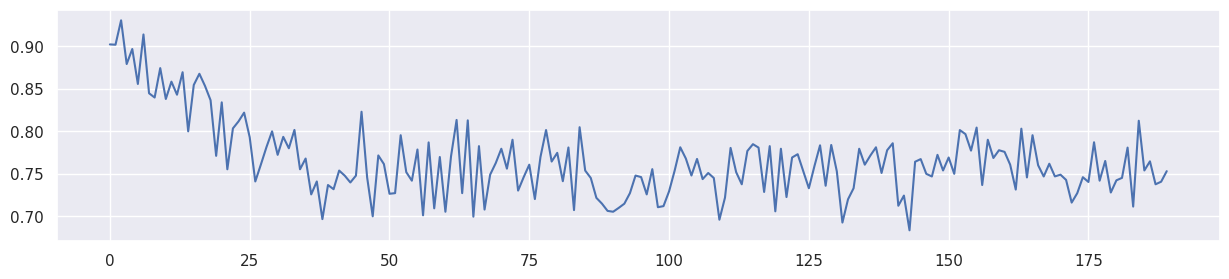

Mean F1 for all data: 0.766193436176715
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 130.848816] [G loss: 0.659845]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 265.214142] [G loss: 0.565364]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 303.004089] [G loss: 0.509898]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 335.394379] [G loss: 0.468733]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 346.626831] [G loss: 0.432649]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 310.460754] [G loss: 0.399048]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 261.200592] [G loss: 0.366380]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 221.777466] [G loss: 0.335798]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 186.678055] [G loss: 0.309152]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 133.671494] [G loss: 0.282780]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 113.727760] [G loss: 0.262834]
[Lambda: 0.100000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 539.10it/s]


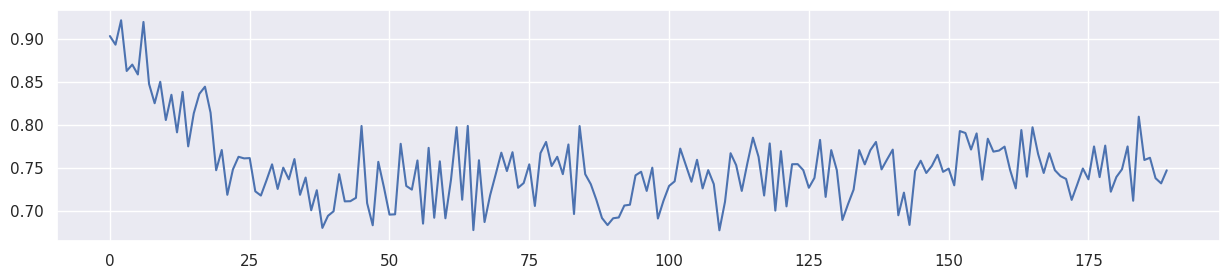

Mean F1 for all data: 0.7510459867874042
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 112.199013] [G loss: 0.660854]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 267.115204] [G loss: 0.561871]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 291.199036] [G loss: 0.511704]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 314.627533] [G loss: 0.471671]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 301.999908] [G loss: 0.436539]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 269.775848] [G loss: 0.403392]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 230.304611] [G loss: 0.371965]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 189.525192] [G loss: 0.342066]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 155.514221] [G loss: 0.315481]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 124.835754] [G loss: 0.290266]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 96.165504] [G loss: 0.267913]
[Lambda: 0.200000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 541.69it/s]


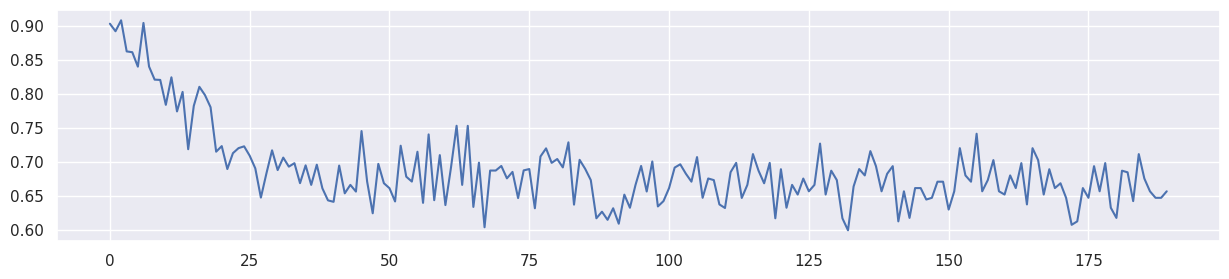

Mean F1 for all data: 0.6885285562454648
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 106.792549] [G loss: 0.662673]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 231.389114] [G loss: 0.568573]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 251.297470] [G loss: 0.513298]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 263.619781] [G loss: 0.472364]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 249.872452] [G loss: 0.436446]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 221.528458] [G loss: 0.402857]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 187.304153] [G loss: 0.369931]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 156.980606] [G loss: 0.338645]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 120.886703] [G loss: 0.310040]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 102.935104] [G loss: 0.282204]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 93.408119] [G loss: 0.262869]
[Lambda: 0.300000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 406.37it/s]


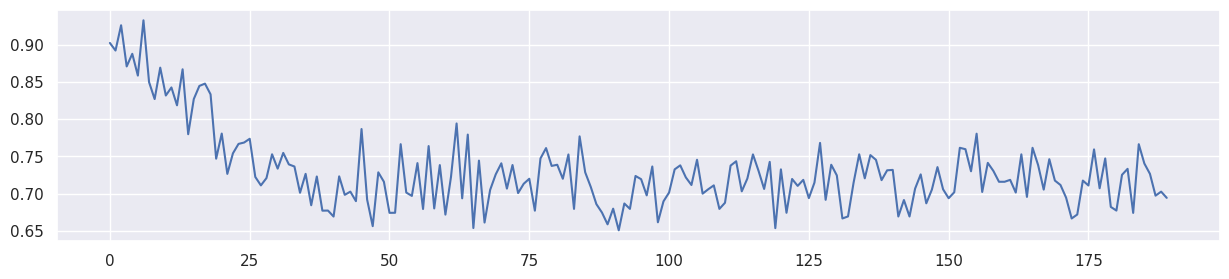

Mean F1 for all data: 0.7305456160447789
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 103.161804] [G loss: 0.663786]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 240.689926] [G loss: 0.564108]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 248.527756] [G loss: 0.513131]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 245.341568] [G loss: 0.473877]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 221.066330] [G loss: 0.437461]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 196.821808] [G loss: 0.402031]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 162.402924] [G loss: 0.368369]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 137.164688] [G loss: 0.336326]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 117.509300] [G loss: 0.308663]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 93.761650] [G loss: 0.280566]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 84.501495] [G loss: 0.261566]
[Lambda: 0.400000] [Epoch 2400/4

100%|██████████| 190/190 [00:00<00:00, 487.08it/s]


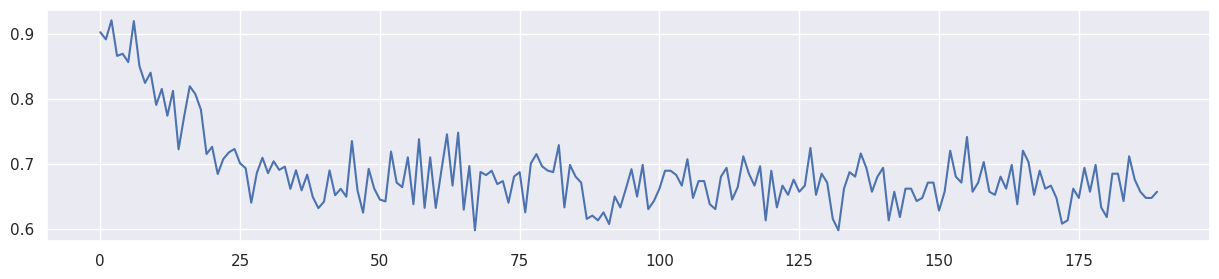

Mean F1 for all data: 0.6866823442322804
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 104.931808] [G loss: 0.663730]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 224.492981] [G loss: 0.565896]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 228.601776] [G loss: 0.513983]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 215.703339] [G loss: 0.475186]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 193.440140] [G loss: 0.437898]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 170.078964] [G loss: 0.401652]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 144.351135] [G loss: 0.366459]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 122.269508] [G loss: 0.334022]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 98.929451] [G loss: 0.304063]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 85.266151] [G loss: 0.275966]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 79.277740] [G loss: 0.256489]
[Lambda: 0.500000] [Epoch 2400/40

100%|██████████| 190/190 [00:00<00:00, 502.98it/s]


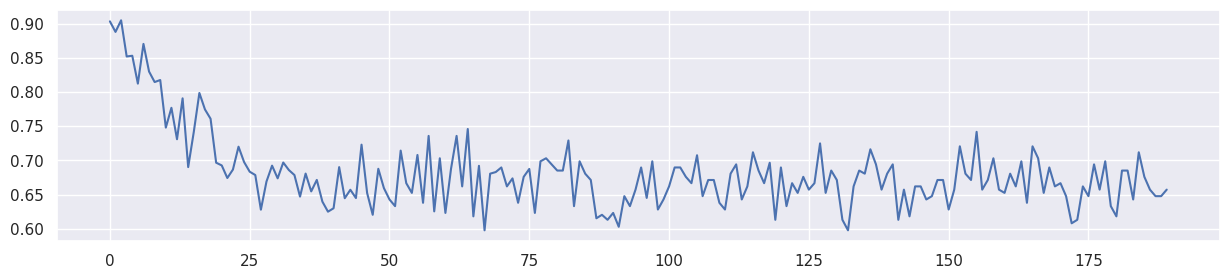

Mean F1 for all data: 0.6812580484299046
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 102.333725] [G loss: 0.664550]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 204.346161] [G loss: 0.569394]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 207.147049] [G loss: 0.515760]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 190.366425] [G loss: 0.476754]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 168.754623] [G loss: 0.438771]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 146.340927] [G loss: 0.400583]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 127.802948] [G loss: 0.363793]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 110.723701] [G loss: 0.331044]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 90.861679] [G loss: 0.298466]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 81.938431] [G loss: 0.271389]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 77.135628] [G loss: 0.252953]
[Lambda: 0.600000] [Epoch 2400/40

100%|██████████| 190/190 [00:00<00:00, 451.79it/s]


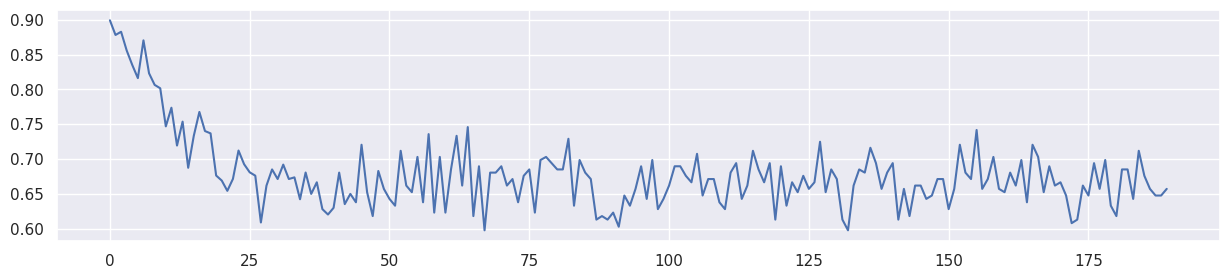

Mean F1 for all data: 0.678634869881244
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 101.315392] [G loss: 0.664424]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 177.895065] [G loss: 0.574228]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 185.173141] [G loss: 0.518693]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 166.060654] [G loss: 0.479187]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 145.544769] [G loss: 0.440375]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 127.580086] [G loss: 0.400970]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 109.121498] [G loss: 0.363643]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 93.102638] [G loss: 0.326843]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 83.472900] [G loss: 0.293661]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 78.464485] [G loss: 0.269499]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 75.252090] [G loss: 0.252317]
[Lambda: 0.700000] [Epoch 2400/4000

100%|██████████| 190/190 [00:00<00:00, 435.90it/s]


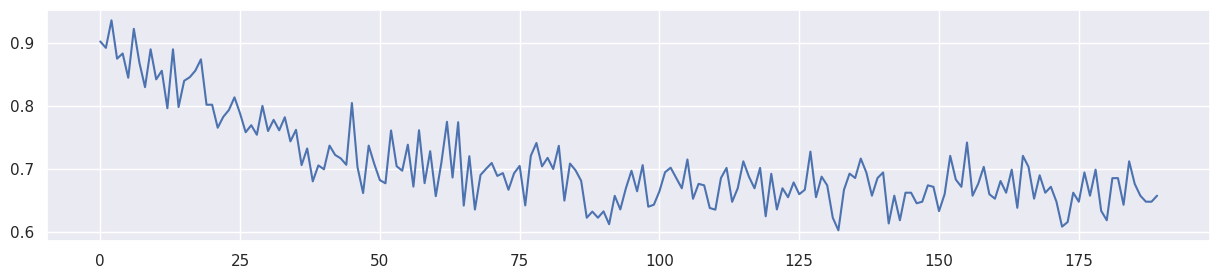

Mean F1 for all data: 0.7065134106291501
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 96.809776] [G loss: 0.666510]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 150.075836] [G loss: 0.585247]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 155.116028] [G loss: 0.526039]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 139.443436] [G loss: 0.481792]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 122.066032] [G loss: 0.438023]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 106.542671] [G loss: 0.392773]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 80.559944] [G loss: 0.325838]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 67.673447] [G loss: 0.284950]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 59.061428] [G loss: 0.259307]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 52.516602] [G loss: 0.243774]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 47.622524] [G loss: 0.234982]
[Lambda: 0.800000] [Epoch 2400/4000]

100%|██████████| 190/190 [00:00<00:00, 489.50it/s]


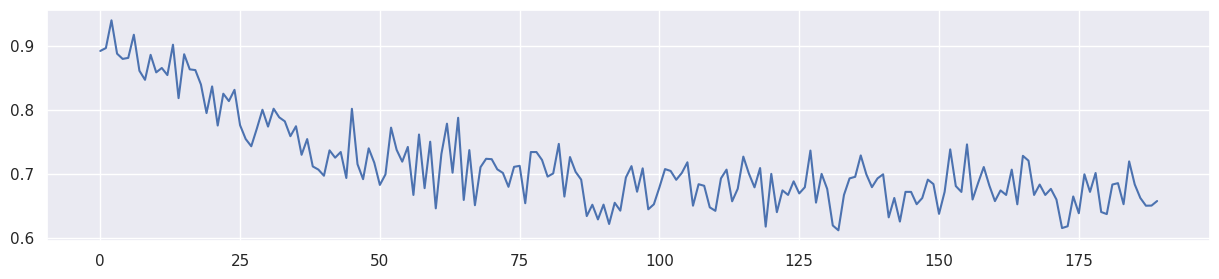

Mean F1 for all data: 0.7153869144805459
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 103.415932] [G loss: 0.686682]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 93.285744] [G loss: 0.669154]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 102.831596] [G loss: 0.624444]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 116.154800] [G loss: 0.550588]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 111.756180] [G loss: 0.486730]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 101.850128] [G loss: 0.431620]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 92.253128] [G loss: 0.378001]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 85.106590] [G loss: 0.328831]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 80.545464] [G loss: 0.289388]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 77.223610] [G loss: 0.260504]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 74.884178] [G loss: 0.242244]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 72.941666] [G loss: 0.231293]
[Lambda: 0.900000] [Epoch 2400/4000] 

100%|██████████| 190/190 [00:00<00:00, 516.38it/s]


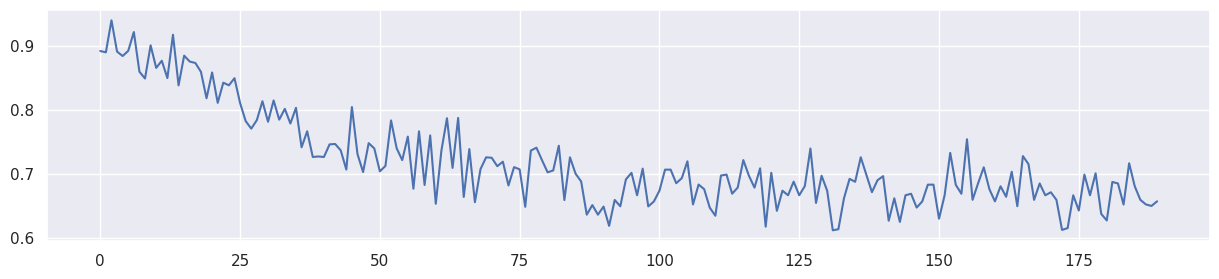

Mean F1 for all data: 0.7192586465146487


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.888889  0.721361  0.603352  0.259820
2        0.2  0.868571  0.883495  0.723197  0.592179  0.245552
3        0.3  0.868571  0.884615  0.726365  0.610169  0.245552
4        0.4  0.868571  0.896226  0.730987  0.621469  0.245552
5        0.5  0.875000  0.896226  0.735199  0.633333  0.243805
6        0.6  0.870056  0.896226  0.746061  0.644068  0.228285
7        0.7  0.868571  0.902326  0.764333  0.662983  0.230407
8        0.8  0.791209  0.875000  0.813504  0.801802  0.100854
9        0.9  0.435233  0.475248  0.481489  0.560000  0.265575
0        0.0  0.870056  0.902326  0.766193  0.753138  0.228285
1        0.1  0.855556  0.903226  0.751046  0.746888  0.194046
2        0.2  0.860335  0.903226  0.688529  0.657244  0.201496
3        0.3  0.870056  0.902326  0.730546  0.694340  0.220950
4        0.4  0.860335  0.903226  0.686682  0.657244  0.201496
5        0.5  0.849162  0.903226  0.681258  0.657244  0.212264
6        0.6  0.844444  0.899083  0.678635  0.657244  0.199816
7        0.7  0.860335  0.902326  0.706513  0.657244  0.194640
8        0.8  0.863636  0.892019  0.715387  0.657143  0.239344
9        0.9  0.842697  0.892019  0.719259  0.657244  0.202988

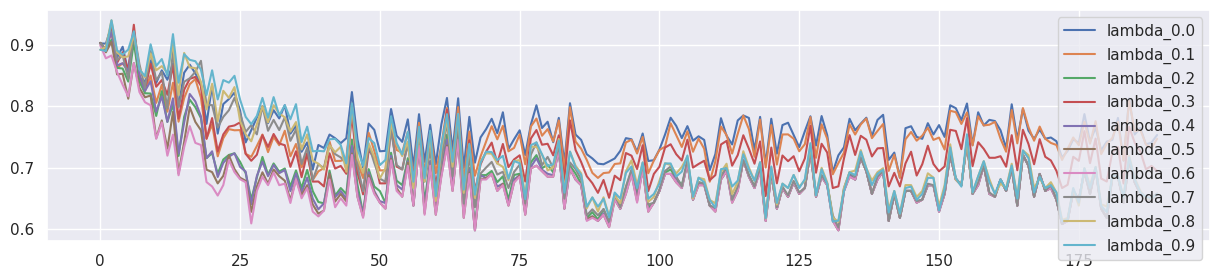

In [145]:
seed_everything()

train_result = []

avaible_range = 1

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.0001)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



+ bucket number를 normalize하면 모델의 유효기간을 설정할 수 있다.
+ 즉, 유효기간까지는 model의 성능을 보전 시킬 수 있는 개념
+ 상기 모든 처리를 그대로 두고 bucket number를 normalize 하여 실험 한다.

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 108.244400] [G loss: 0.663271]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 231.880386] [G loss: 0.572146]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 270.650635] [G loss: 0.512678]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 316.379883] [G loss: 0.471908]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 347.266449] [G loss: 0.436837]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 345.950165] [G loss: 0.405479]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 316.007111] [G loss: 0.375412]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 283.123444] [G loss: 0.345048]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 217.554138] [G loss: 0.316754]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 198.166306] [G loss: 0.291417]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 178.515823] [G loss: 0.271767]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 166.529114] [G loss: 0.25

100%|██████████| 190/190 [00:00<00:00, 544.23it/s]


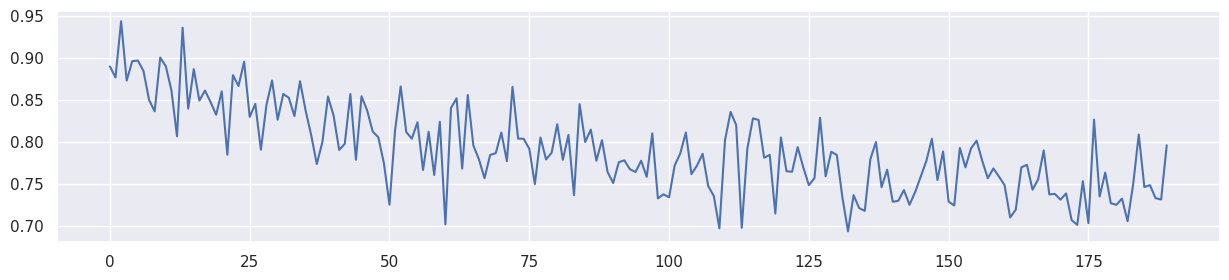

Mean F1 for all data: 0.7906927877053461
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 106.586128] [G loss: 0.663440]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 227.187408] [G loss: 0.571864]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 264.252106] [G loss: 0.512691]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 295.773956] [G loss: 0.472253]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 309.502167] [G loss: 0.436596]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 298.191345] [G loss: 0.403983]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 268.426453] [G loss: 0.372724]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 227.372833] [G loss: 0.342680]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 180.825089] [G loss: 0.313135]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 158.982819] [G loss: 0.287995]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 145.271851] [G loss: 0.268729]
[Lambda: 0.100000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 552.57it/s]


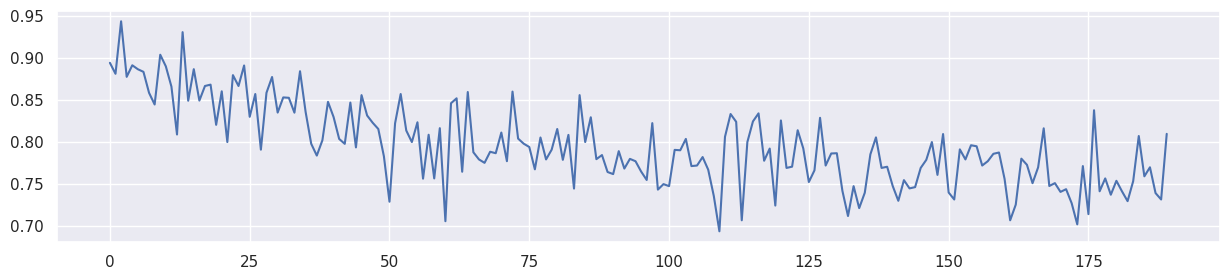

Mean F1 for all data: 0.7957761841603329
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 104.833504] [G loss: 0.663741]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 222.103943] [G loss: 0.572062]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 254.232391] [G loss: 0.512820]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 274.233948] [G loss: 0.472691]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 278.816833] [G loss: 0.428700]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 245.688461] [G loss: 0.370912]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 202.188263] [G loss: 0.344445]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 159.681503] [G loss: 0.315017]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 127.775536] [G loss: 0.288756]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 111.365044] [G loss: 0.270152]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 93.885414] [G loss: 0.256915]
[Lambda: 0.200000] [Epoch 2400/4

100%|██████████| 190/190 [00:00<00:00, 541.79it/s]


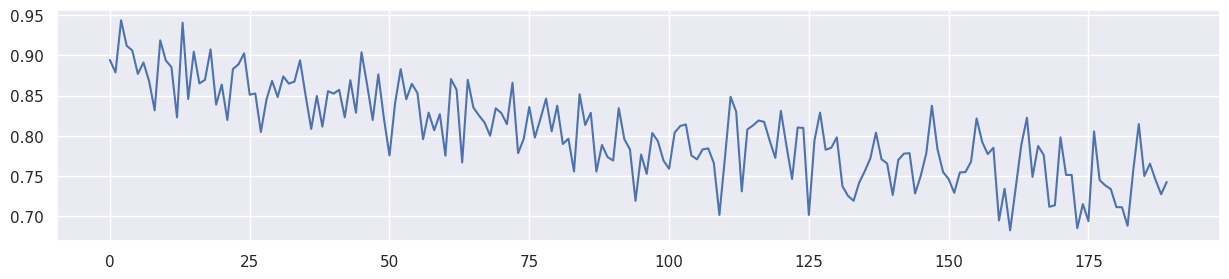

Mean F1 for all data: 0.8038933753369044
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 102.904663] [G loss: 0.664138]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 216.213348] [G loss: 0.572689]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 242.706161] [G loss: 0.513100]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 252.518005] [G loss: 0.473147]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 244.788193] [G loss: 0.436943]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 222.986084] [G loss: 0.402441]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 195.602859] [G loss: 0.369618]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 155.445435] [G loss: 0.337699]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 134.519379] [G loss: 0.308094]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 119.471664] [G loss: 0.283423]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 106.189621] [G loss: 0.264831]
[Lambda: 0.300000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 485.22it/s]


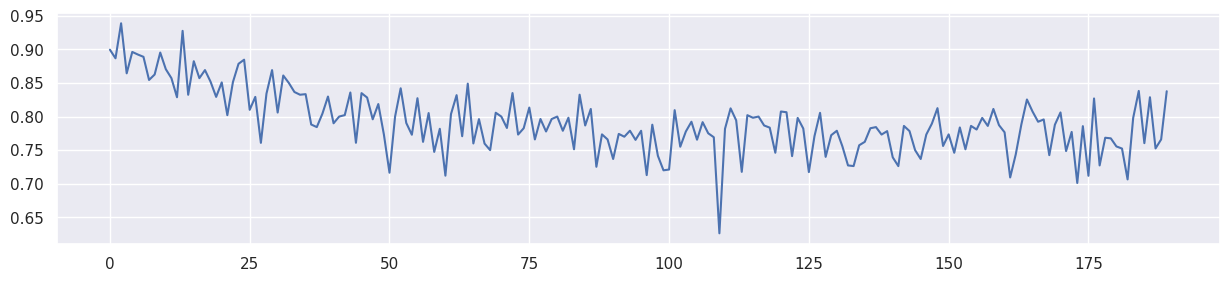

Mean F1 for all data: 0.79227377318358
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 101.598022] [G loss: 0.664679]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 208.453873] [G loss: 0.573696]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 231.944717] [G loss: 0.513598]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 231.285263] [G loss: 0.473959]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 214.372513] [G loss: 0.437608]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 195.084946] [G loss: 0.402036]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 164.416367] [G loss: 0.368556]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 140.073227] [G loss: 0.336388]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 121.236008] [G loss: 0.306305]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 109.356659] [G loss: 0.281885]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 100.800735] [G loss: 0.263896]
[Lambda: 0.400000] [Epoch 2400/40

100%|██████████| 190/190 [00:00<00:00, 530.41it/s]


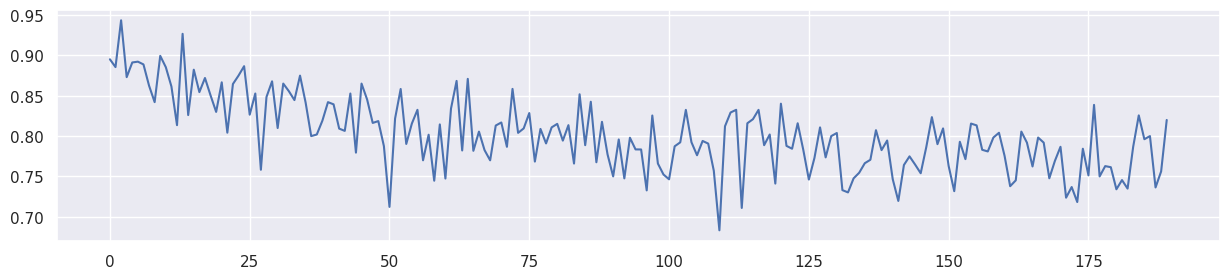

Mean F1 for all data: 0.8019992796162132
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 99.976013] [G loss: 0.665446]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 197.740768] [G loss: 0.575807]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 215.378036] [G loss: 0.514668]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 208.875305] [G loss: 0.475145]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 189.074142] [G loss: 0.439195]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 163.819885] [G loss: 0.403023]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 138.492691] [G loss: 0.367535]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 120.358437] [G loss: 0.334475]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 104.954514] [G loss: 0.304199]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 84.834450] [G loss: 0.277846]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 75.134651] [G loss: 0.255656]
[Lambda: 0.500000] [Epoch 2400/400

100%|██████████| 190/190 [00:00<00:00, 510.08it/s]


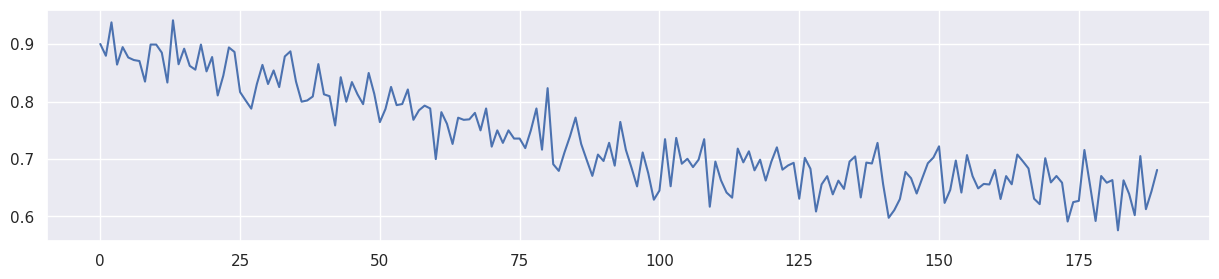

Mean F1 for all data: 0.735099206859942
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 97.884315] [G loss: 0.666495]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 182.538986] [G loss: 0.578879]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 200.566605] [G loss: 0.516173]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 188.717773] [G loss: 0.477070]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 167.891052] [G loss: 0.439294]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 147.217743] [G loss: 0.401562]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 128.246216] [G loss: 0.365525]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 109.801674] [G loss: 0.332201]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 95.298729] [G loss: 0.300881]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 83.204254] [G loss: 0.274597]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 77.566147] [G loss: 0.256162]
[Lambda: 0.600000] [Epoch 2400/4000]

100%|██████████| 190/190 [00:00<00:00, 533.04it/s]


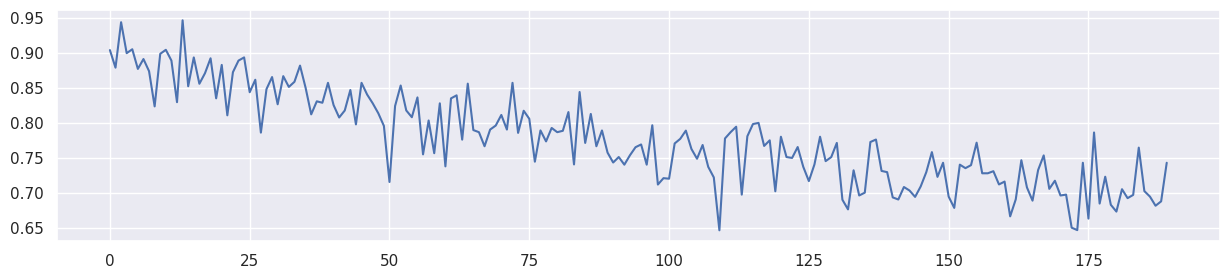

Mean F1 for all data: 0.7773766830655156
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 95.617081] [G loss: 0.668072]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 159.376251] [G loss: 0.592565]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 182.198792] [G loss: 0.520650]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 163.655701] [G loss: 0.480577]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 142.426056] [G loss: 0.441924]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 122.670700] [G loss: 0.402295]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 105.393608] [G loss: 0.361695]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 91.488159] [G loss: 0.323456]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 82.901329] [G loss: 0.289446]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 77.508179] [G loss: 0.264981]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 73.974007] [G loss: 0.247732]
[Lambda: 0.700000] [Epoch 2400/4000]

100%|██████████| 190/190 [00:00<00:00, 524.70it/s]


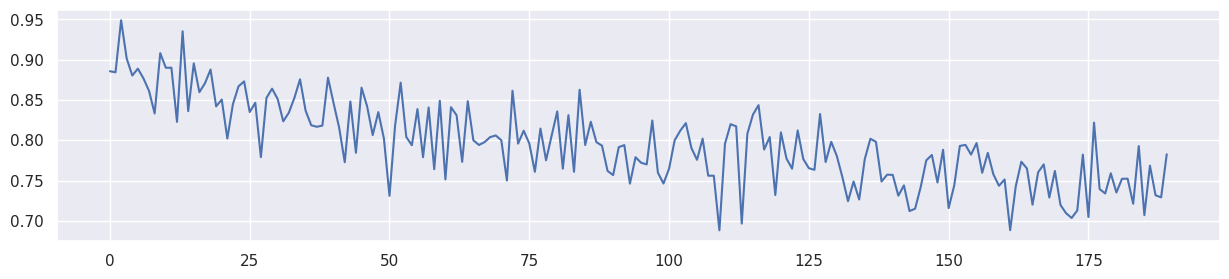

Mean F1 for all data: 0.7957398976140948
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 93.004219] [G loss: 0.670035]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 96.811317] [G loss: 0.639454]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 156.266525] [G loss: 0.538918]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 139.999710] [G loss: 0.486987]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 120.734375] [G loss: 0.440820]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 104.637573] [G loss: 0.394389]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 91.798897] [G loss: 0.349243]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 83.576752] [G loss: 0.308760]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 78.405769] [G loss: 0.276799]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 75.164810] [G loss: 0.254623]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 72.953606] [G loss: 0.240965]
[Lambda: 0.800000] [Epoch 2400/4000] [

100%|██████████| 190/190 [00:00<00:00, 540.62it/s]


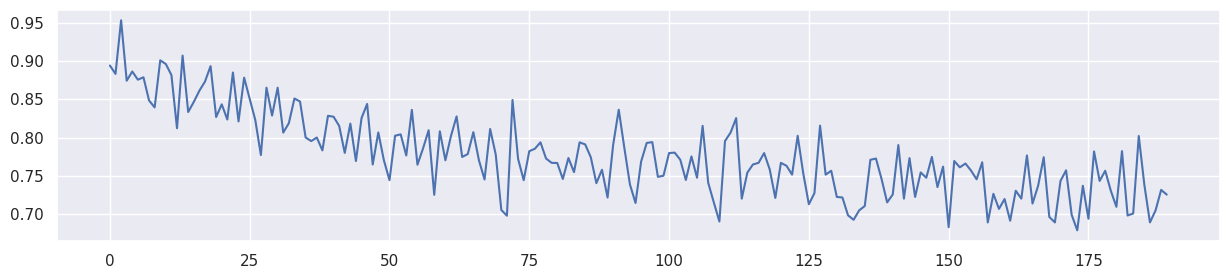

Mean F1 for all data: 0.776999755250658
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 69.259216] [G loss: 0.675620]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 33.340889] [G loss: 0.643958]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 33.844917] [G loss: 0.610243]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 33.937340] [G loss: 0.577787]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 30.731037] [G loss: 0.535794]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 40.310623] [G loss: 0.327636]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 41.291790] [G loss: 0.269956]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 36.888733] [G loss: 0.252062]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 34.390762] [G loss: 0.242328]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 33.020802] [G loss: 0.236297]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 32.276066] [G loss: 0.232493]
[Lambda: 0.900000] [Epoch 2400/4000] [mi lo

100%|██████████| 190/190 [00:00<00:00, 504.24it/s]


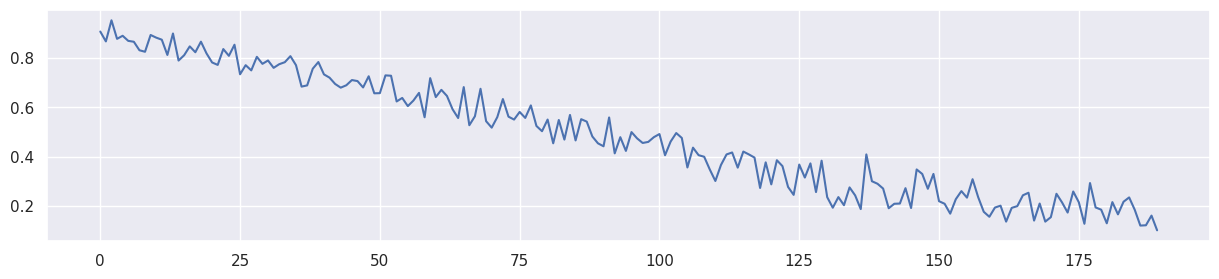

Mean F1 for all data: 0.48447631207747555


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.888889  0.721361  0.603352  0.259820
2        0.2  0.868571  0.883495  0.723197  0.592179  0.245552
3        0.3  0.868571  0.884615  0.726365  0.610169  0.245552
4        0.4  0.868571  0.896226  0.730987  0.621469  0.245552
5        0.5  0.875000  0.896226  0.735199  0.633333  0.243805
6        0.6  0.870056  0.896226  0.746061  0.644068  0.228285
7        0.7  0.868571  0.902326  0.764333  0.662983  0.230407
8        0.8  0.791209  0.875000  0.813504  0.801802  0.100854
9        0.9  0.435233  0.475248  0.481489  0.560000  0.265575
0        0.0  0.875000  0.889952  0.790693  0.796117  0.273380
1        0.1  0.870056  0.894231  0.795776  0.809756  0.274603
2        0.2  0.873563  0.894231  0.803893  0.742574  0.245810
3        0.3  0.880000  0.899522  0.792274  0.837696  0.270678
4        0.4  0.886364  0.895238  0.801999  0.820000  0.267034
5        0.5  0.880000  0.900474  0.735099  0.681081  0.231494
6        0.6  0.875000  0.903846  0.777377  0.743119  0.240431
7        0.7  0.863636  0.885714  0.795740  0.782609  0.222797
8        0.8  0.868571  0.894231  0.777000  0.725275  0.213551
9        0.9  0.870588  0.907317  0.484476  0.102041  0.245861

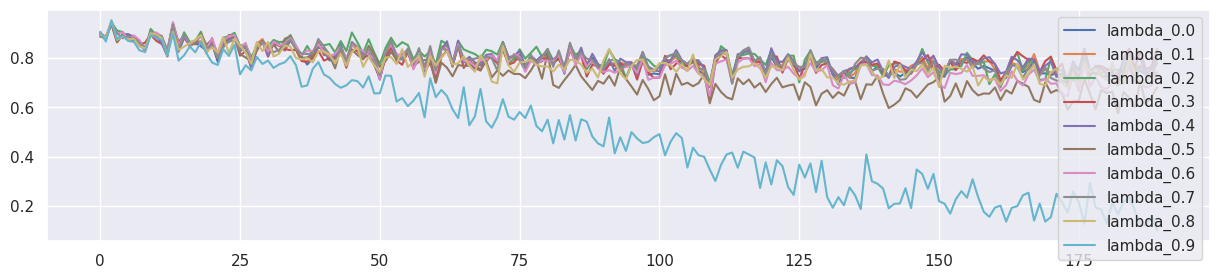

In [154]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.0001)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



+ 유효기간을 더 연장하다.

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 108.204147] [G loss: 0.663318]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 232.519302] [G loss: 0.572386]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 271.043427] [G loss: 0.512893]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 317.433746] [G loss: 0.471979]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 344.928345] [G loss: 0.436845]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 349.728668] [G loss: 0.405180]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 319.848877] [G loss: 0.374648]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 287.094727] [G loss: 0.345045]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 241.474457] [G loss: 0.317704]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 198.581284] [G loss: 0.291503]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 174.788605] [G loss: 0.271732]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 159.900757] [G loss: 0.25

100%|██████████| 190/190 [00:00<00:00, 554.64it/s]


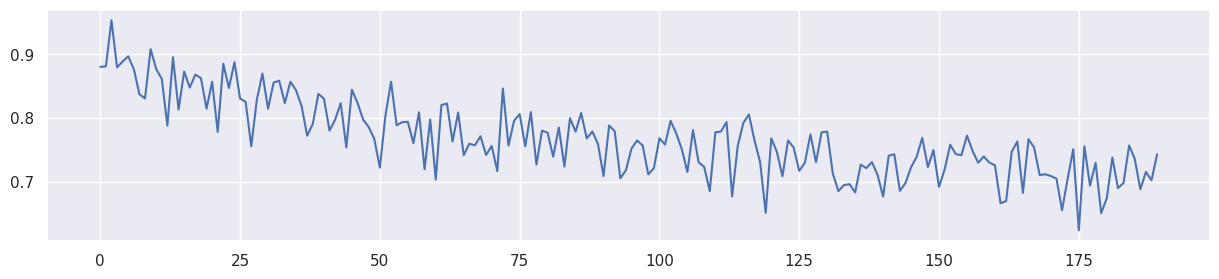

Mean F1 for all data: 0.7684447054994978
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 106.565605] [G loss: 0.663489]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 227.658142] [G loss: 0.572104]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 262.909363] [G loss: 0.512917]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 296.467834] [G loss: 0.472391]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 309.947418] [G loss: 0.436700]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 294.915222] [G loss: 0.404316]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 265.807983] [G loss: 0.372576]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 228.678650] [G loss: 0.342478]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 179.841995] [G loss: 0.312694]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 155.804169] [G loss: 0.287653]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 134.488708] [G loss: 0.268238]
[Lambda: 0.100000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 532.96it/s]


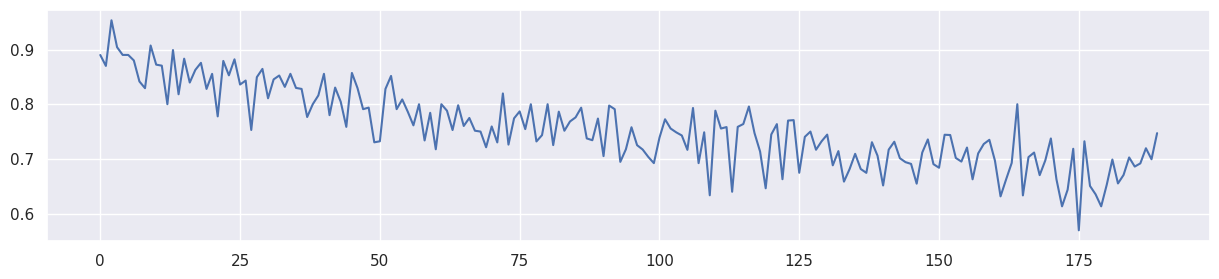

Mean F1 for all data: 0.7561655181753966
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 104.808464] [G loss: 0.663786]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 222.593399] [G loss: 0.572321]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 253.794312] [G loss: 0.513041]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 272.594910] [G loss: 0.472759]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 275.282196] [G loss: 0.436435]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 259.370605] [G loss: 0.377746]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 191.655075] [G loss: 0.345305]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 154.715744] [G loss: 0.314956]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 128.062988] [G loss: 0.288993]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 112.785484] [G loss: 0.270434]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 96.783966] [G loss: 0.257145]
[Lambda: 0.200000] [Epoch 2400/4

100%|██████████| 190/190 [00:00<00:00, 457.01it/s]


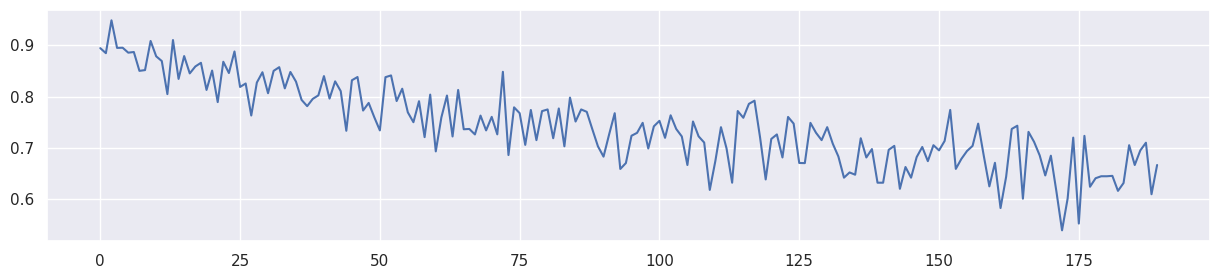

Mean F1 for all data: 0.7432527855938527
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 102.891083] [G loss: 0.664173]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 216.781326] [G loss: 0.572953]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 243.266739] [G loss: 0.513317]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 248.427795] [G loss: 0.473284]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 240.229874] [G loss: 0.437339]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 219.832275] [G loss: 0.402246]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 193.153336] [G loss: 0.369263]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 158.283386] [G loss: 0.338056]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 136.012497] [G loss: 0.308028]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 117.926743] [G loss: 0.283660]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 107.957451] [G loss: 0.264805]
[Lambda: 0.300000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 518.02it/s]


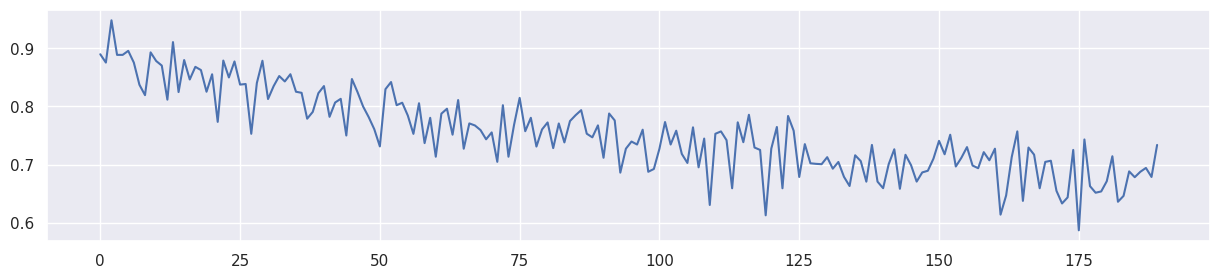

Mean F1 for all data: 0.7536798646697428
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 101.580482] [G loss: 0.664715]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 208.898361] [G loss: 0.573990]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 230.237122] [G loss: 0.513956]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 226.814423] [G loss: 0.474045]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 216.898026] [G loss: 0.437315]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 194.306625] [G loss: 0.401831]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 168.085236] [G loss: 0.368336]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 140.585129] [G loss: 0.336236]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 120.937645] [G loss: 0.306413]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 108.711227] [G loss: 0.281908]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 100.704170] [G loss: 0.264001]
[Lambda: 0.400000] [Epoch 2400/

100%|██████████| 190/190 [00:00<00:00, 536.03it/s]


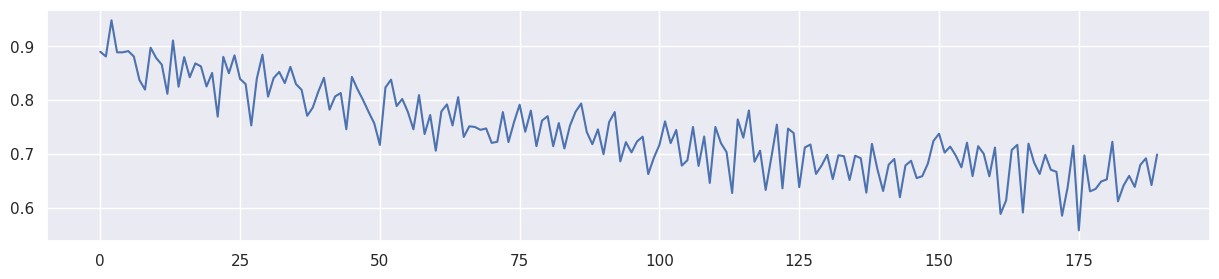

Mean F1 for all data: 0.7417197946051486
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 99.981400] [G loss: 0.665479]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 197.685730] [G loss: 0.576129]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 214.744675] [G loss: 0.514870]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 206.894226] [G loss: 0.475140]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 190.379791] [G loss: 0.438367]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 168.512192] [G loss: 0.401711]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 144.214111] [G loss: 0.367228]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 123.929123] [G loss: 0.334544]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 109.609169] [G loss: 0.304236]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 100.419647] [G loss: 0.280063]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 85.359451] [G loss: 0.253819]
[Lambda: 0.500000] [Epoch 2400/40

100%|██████████| 190/190 [00:00<00:00, 488.90it/s]


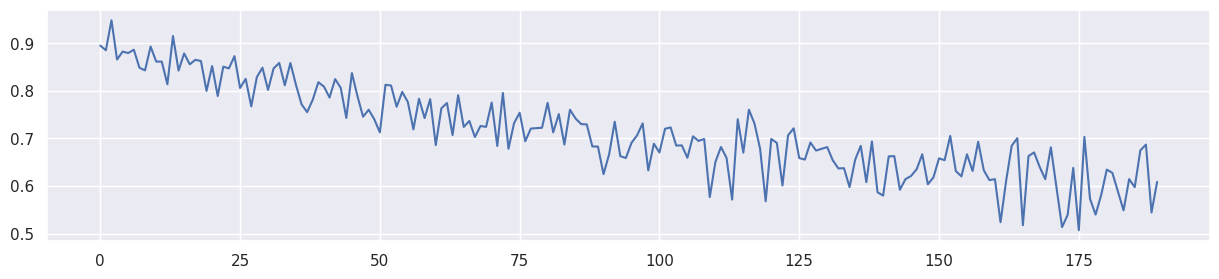

Mean F1 for all data: 0.7145230050017032
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 97.869781] [G loss: 0.666527]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 183.018143] [G loss: 0.579103]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 201.841476] [G loss: 0.516118]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 188.333694] [G loss: 0.477084]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 167.797470] [G loss: 0.439299]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 146.976059] [G loss: 0.401526]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 129.211853] [G loss: 0.365624]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 111.163673] [G loss: 0.331307]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 95.333916] [G loss: 0.300866]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 83.693207] [G loss: 0.274964]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 77.985588] [G loss: 0.256614]
[Lambda: 0.600000] [Epoch 2400/4000

100%|██████████| 190/190 [00:00<00:00, 531.64it/s]


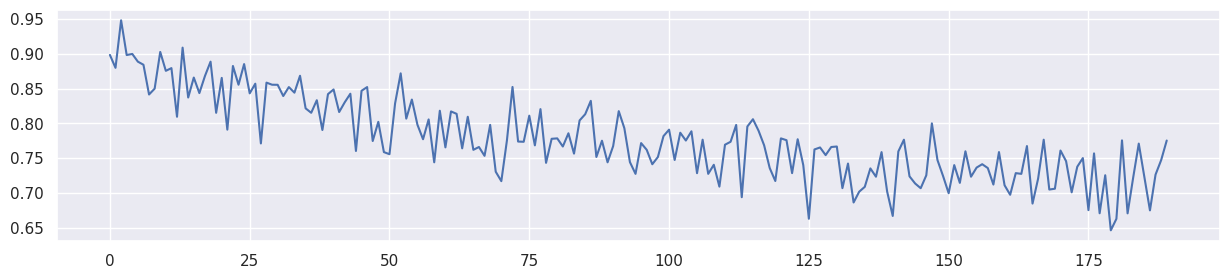

Mean F1 for all data: 0.7779071420599568
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 95.599693] [G loss: 0.668099]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 159.450363] [G loss: 0.592838]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 181.259308] [G loss: 0.520990]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 163.825806] [G loss: 0.480450]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 143.337372] [G loss: 0.441044]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 125.111130] [G loss: 0.400723]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 106.451500] [G loss: 0.362028]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 92.208870] [G loss: 0.323519]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 83.035789] [G loss: 0.290009]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 77.712059] [G loss: 0.265340]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 74.160004] [G loss: 0.247986]
[Lambda: 0.700000] [Epoch 2400/4000]

100%|██████████| 190/190 [00:00<00:00, 519.04it/s]


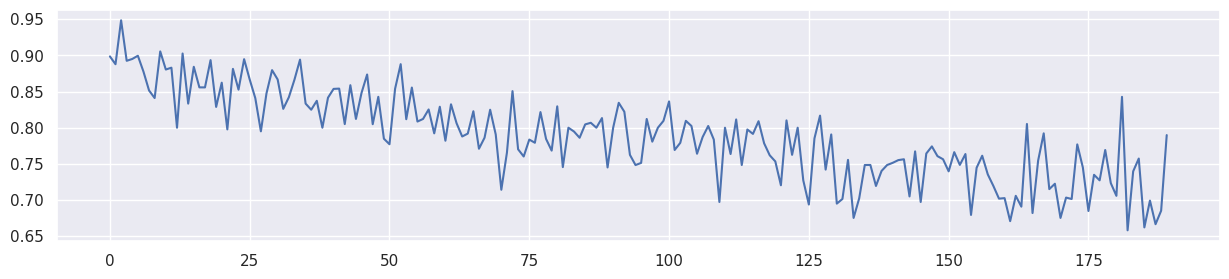

Mean F1 for all data: 0.7882520534018612
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 92.667313] [G loss: 0.670266]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 88.925705] [G loss: 0.646671]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 85.075592] [G loss: 0.616009]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 80.951797] [G loss: 0.576209]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 76.510246] [G loss: 0.524749]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 72.201035] [G loss: 0.466749]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 68.492470] [G loss: 0.413970]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 65.539856] [G loss: 0.374208]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 63.312096] [G loss: 0.349349]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 61.655388] [G loss: 0.335846]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 60.367649] [G loss: 0.328916]
[Lambda: 0.800000] [Epoch 2400/4000] [mi l

100%|██████████| 190/190 [00:00<00:00, 539.30it/s]


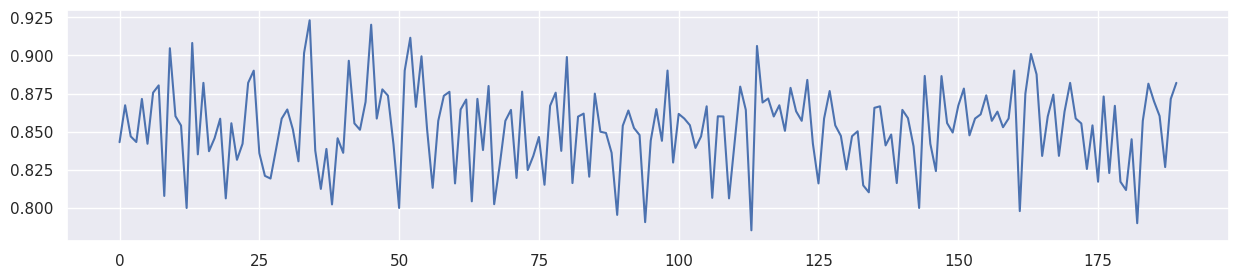

Mean F1 for all data: 0.852363965858868
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 96.862511] [G loss: 0.687078]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 69.249756] [G loss: 0.675638]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 33.612865] [G loss: 0.643964]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 34.206219] [G loss: 0.610220]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 34.353600] [G loss: 0.577735]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 31.287218] [G loss: 0.535383]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 41.051388] [G loss: 0.329589]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 43.468605] [G loss: 0.269885]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 39.332874] [G loss: 0.251288]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 36.804512] [G loss: 0.241162]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 35.367657] [G loss: 0.234869]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 34.453972] [G loss: 0.230905]
[Lambda: 0.900000] [Epoch 2400/4000] [mi lo

100%|██████████| 190/190 [00:00<00:00, 526.18it/s]


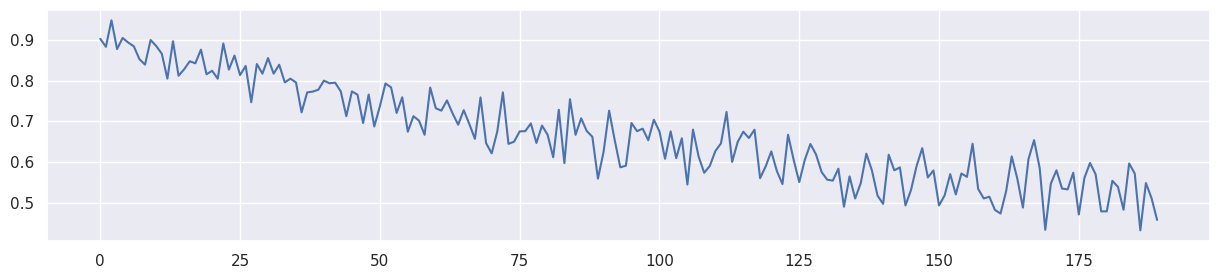

Mean F1 for all data: 0.6675812208726136


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.865169  0.884615  0.716251  0.588889  0.269256
1  Feature 6  0.853659  0.900000  0.125232  0.000000  0.200382
2  Feature 4  0.777143  0.865385  0.852120  0.885417  0.086931
0        0.0  0.875000  0.888889  0.719835  0.600000  0.261667
1        0.1  0.881356  0.888889  0.721361  0.603352  0.259820
2        0.2  0.868571  0.883495  0.723197  0.592179  0.245552
3        0.3  0.868571  0.884615  0.726365  0.610169  0.245552
4        0.4  0.868571  0.896226  0.730987  0.621469  0.245552
5        0.5  0.875000  0.896226  0.735199  0.633333  0.243805
6        0.6  0.870056  0.896226  0.746061  0.644068  0.228285
7        0.7  0.868571  0.902326  0.764333  0.662983  0.230407
8        0.8  0.791209  0.875000  0.813504  0.801802  0.100854
9        0.9  0.435233  0.475248  0.481489  0.560000  0.265575
0        0.0  0.865169  0.880383  0.768445  0.743455  0.286236
1        0.1  0.863636  0.889952  0.756166  0.747126  0.270696
2        0.2  0.867052  0.894231  0.743253  0.666667  0.246896
3        0.3  0.873563  0.889952  0.753680  0.733728  0.249935
4        0.4  0.878613  0.889952  0.741720  0.698795  0.265152
5        0.5  0.873563  0.895238  0.714523  0.608696  0.263214
6        0.6  0.877193  0.898551  0.777907  0.775281  0.241848
7        0.7  0.867052  0.898551  0.788252  0.789809  0.229339
8        0.8  0.781609  0.843137  0.852364  0.882051  0.097429
9        0.9  0.860465  0.902913  0.667581  0.457143  0.244690

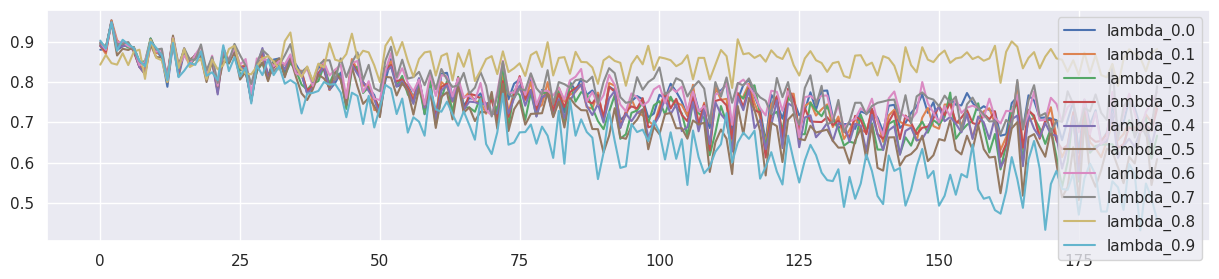

In [155]:
seed_everything()

train_result = []

avaible_range = 2000

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.0001)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])

